# Intro
- Code to train YOLO model to predict images from T80_kenji

In [1]:
!pip install -q ultralytics==8.0.154

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.0/613.0 kB 5.3 MB/s eta 0:00:00


In [2]:
!pip install -q adjustText==0.8

In [3]:
!pip install -q plotly==5.15.0

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import h5py

In [6]:
import inspect

In [7]:
import os
import random
import shutil
import pandas as pd
import numpy as np

from datetime import datetime

In [8]:
from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema
import scipy.stats as stats
import scipy.io
from scipy.optimize import linear_sum_assignment

from sklearn.mixture import GaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from skimage.feature import peak_local_max
import skimage.color
import skimage.filters

In [9]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from adjustText import adjust_text
import plotly.graph_objects as go

In [10]:
from ultralytics import YOLO

In [11]:
import seaborn as sns

In [12]:
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

In [13]:
from ultralytics.utils import plotting

In [14]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/")

['Data',
 'image_preprocessors.ipynb',
 'image_extractors.ipynb',
 'Models',
 'transforms.ipynb',
 'Results',
 'experimentation.ipynb',
 'yolo_labelling.ipynb',
 'archived_code.ipynb',
 'auxiliary_functions.ipynb',
 'gaussian_generator.ipynb',
 'Draws',
 'gaussian_estimation.ipynb',
 'run_estimation_3.ipynb',
 'run_estimation_4.ipynb',
 'data_analysis.ipynb',
 'aux_plotter.ipynb',
 'run_estimation_2.ipynb',
 'pipelines.ipynb',
 'error_estimation.ipynb',
 'run_estimation_A.ipynb',
 'run_estimation_12.ipynb',
 'predict_T80Kenji.ipynb']

# Load modules

In [15]:
# Load some modulus
# Auxiliary functions in computation and plotting
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/auxiliary_functions.ipynb"
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/aux_plotter.ipynb"

# Pipelines contain steps of the analysis from the "initial" data to the final result
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/pipelines.ipynb"

# Transforms contain the transformations of the image (example laplacian)
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/transforms.ipynb"

# Image extractors
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/image_extractors.ipynb"

# Dist generation
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/gaussian_generator.ipynb"

# Dist estimation
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/gaussian_estimation.ipynb"

# Yolo labelling
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/yolo_labelling.ipynb"

# Error estimation
%run "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/error_estimation.ipynb"

In [16]:
print(inspect.getsource(extract_region))

def extract_region(x,
                   y,
                   image,
                   center,
                   covariance,
                   return_cropped = True):
  """
  Returns the filtered region
  ---
  : returns
  :: cropped_region : 2D array with only the region
  :: sub_region: 2D array with original shape, nan values for outside region
  """
  # Get the region around the center
  x_min = center[0] - np.sqrt(covariance[0, 0])
  x_max = center[0] + np.sqrt(covariance[0, 0])
  y_min = center[1] - np.sqrt(covariance[1, 1])
  y_max = center[1] + np.sqrt(covariance[1, 1])

  # Creating mask for 2D arrays
  mask_x = np.logical_and(x >= x_min, x <= x_max)
  mask_y = np.logical_and(y >= y_min, y <= y_max)
  mask = np.logical_and(mask_x, mask_y)

  sub_region = np.where(mask, image, np.nan)

  if return_cropped:
    # Find the cropping box coordinates (non-nan values)
    rows = np.any(~np.isnan(sub_region), axis=1)
    cols = np.any(~np.isnan(sub_region), axis=0)
    rowmin, row

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [17]:
filename = '/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/T80_kenji.mat'
mat = {}
with h5py.File(filename, 'r') as f:
    # Print all keys in the file
    print(list(f.keys()))
    for i_key in f.keys():
      mat.update({i_key: f[i_key][:]})

['T2fit', 'val_fit']


In [18]:
# Renaming as the previous data
mat['F_data'] = mat['T2fit']
mat['Fit_flux'] = mat['val_fit']
del mat['T2fit']
del mat['val_fit']

In [19]:
# Transposing to match the organization of the previous database
mat['F_data'] = mat['F_data'].T
mat['Fit_flux'] = mat['Fit_flux'].T

In [20]:
# Generate GRID
width = mat['F_data'].shape[1]
length = mat['F_data'].shape[0]
x, y = generate_grid((0, width),
                     (0, length),
                     mat['F_data'].shape[1],
                     mat['F_data'].shape[0])

In [21]:
print(mat['F_data'].shape)
print(x.shape)
print(y.shape)

(180, 72, 400)
(180, 72)
(180, 72)


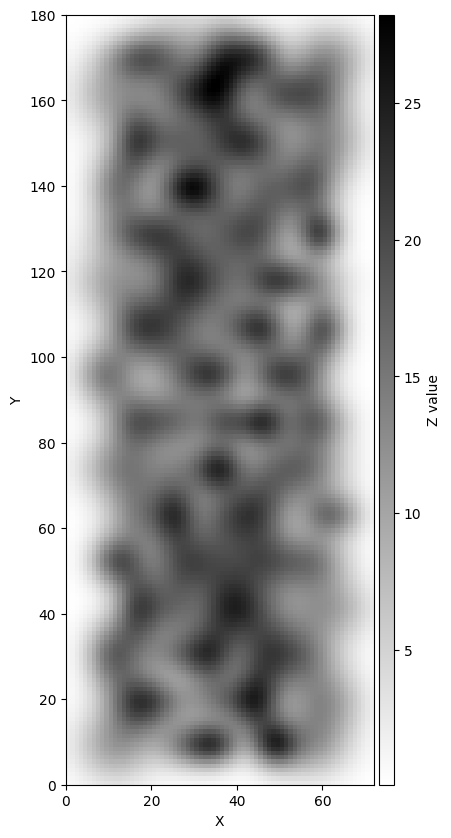

In [22]:
fig, ax = plt.subplots(figsize = (15, 10))
plot_grayscale(x, y, mat['F_data'][:, :, 0], ax = ax)

## CONFIG RUN

In [23]:
# Keep RUN parameters
CONFIG_RUN = {'image_ranges' : [(0, width), (0, length)],
              'image_size' : [mat['F_data'].shape[1], mat['F_data'].shape[0]]}

## Save all gaussian

In [ ]:
def save_all_gaussians(mat):
  """
  Save all gaussians while maintaning the pixel dimensions
  Extracted from: https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
  """
  for save_id in range(0, mat['F_data'].shape[0]):
    plt.imsave(fname = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/gaussian_{save_id}.png",
               arr = mat['F_data'][:, :, save_id],
               cmap='gray_r',
               format='png')

In [ ]:
# Saving pngs
# save_all_gaussians(mat)

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [ ]:
# Load data
n_image = 313

# Image - z intensities
image = [x, y, mat['F_data'][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Structure covariances
covariances = [np.diag(cov) for cov in zip((dispersion_x/np.sqrt(2)/1000)**2, (dispersion_y/np.sqrt(2)/1000)**2)]

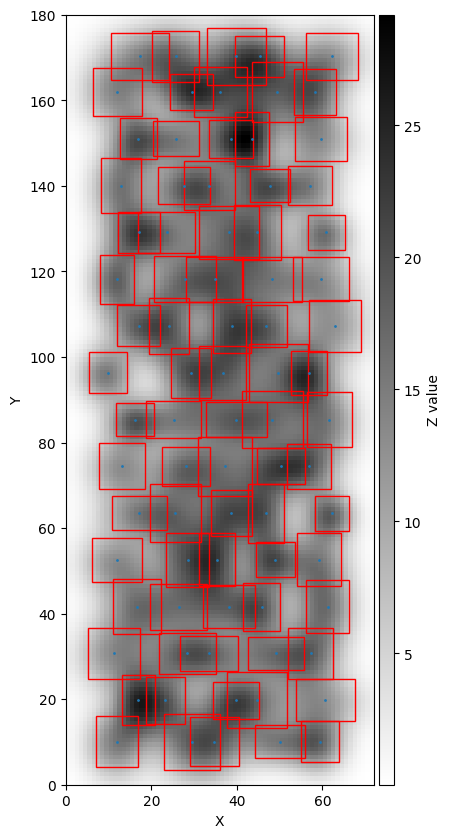

In [ ]:
# Display the image
fig, ax = plt.subplots(1, figsize = (15, 10))
plot_boxes_gmm(means = list(zip(xs/1000, ys/1000)),
               covariances = covariances,
               ax = ax,
               beta = 3)
ax.scatter(xs, ys, s = 1)
plot_grayscale(x, y, image[-1], colorbar = True, ax = ax)

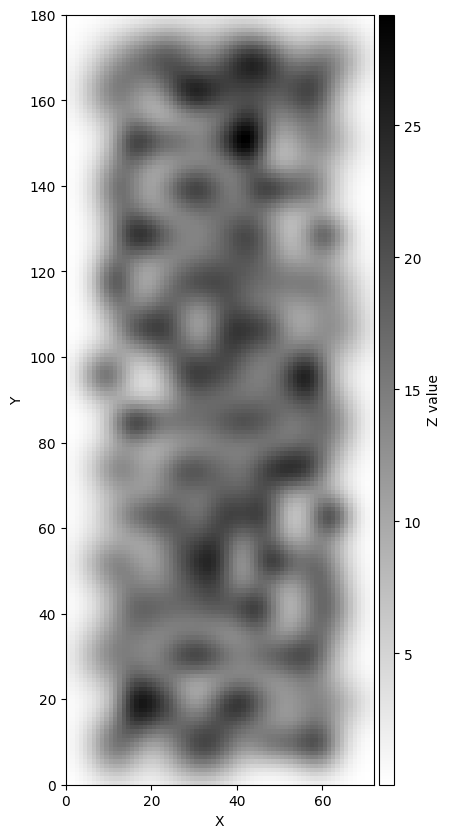

In [ ]:
# Display the image
fig, ax = plt.subplots(1, figsize = (15, 10))
plot_grayscale(x, y, image[-1], colorbar = True, ax = ax)

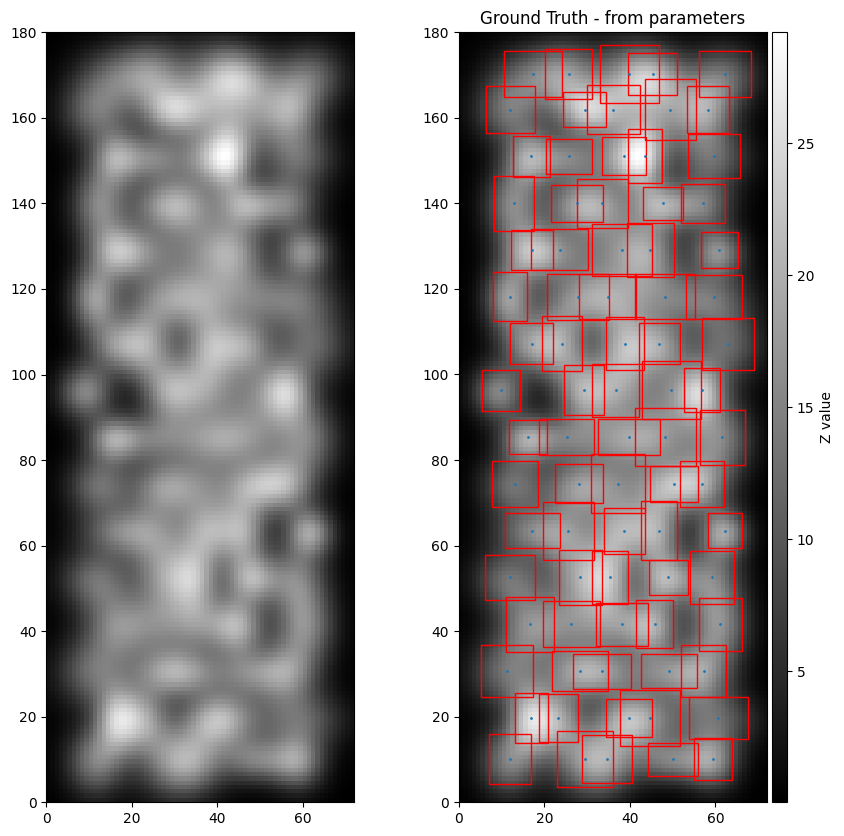

In [ ]:
# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize = (10, 10))

# Display the image
plot_boxes_gmm(means = list(zip(xs/1000, ys/1000)),
               covariances = covariances,
               ax = axs[1],
               beta = 3)
axs[1].set_title("Ground Truth - from parameters")
axs[1].scatter(xs, ys, s = 1)

# Image
plot_grayscale(x, y, image[-1], colorbar = False, ax = axs[0])
plot_grayscale(x, y, image[-1], colorbar = True, ax = axs[1])

for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

## Dataset analysis

In [ ]:
# Mean values of parameters for each image
mean_amplitudes = []
mean_xss = []
mean_yss = []
mean_dispersion_xss = []
mean_dispersion_yss = []

for n_image in range(len(mat['Fit_flux'])):
  # Parameters extraction
  amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)
  mean_amplitudes.append(np.mean(amplitude))
  mean_xss.append(np.mean(xs))
  mean_yss.append(np.mean(ys))
  mean_dispersion_xss.append(np.mean(dispersion_x))
  mean_dispersion_yss.append(np.mean(dispersion_y))

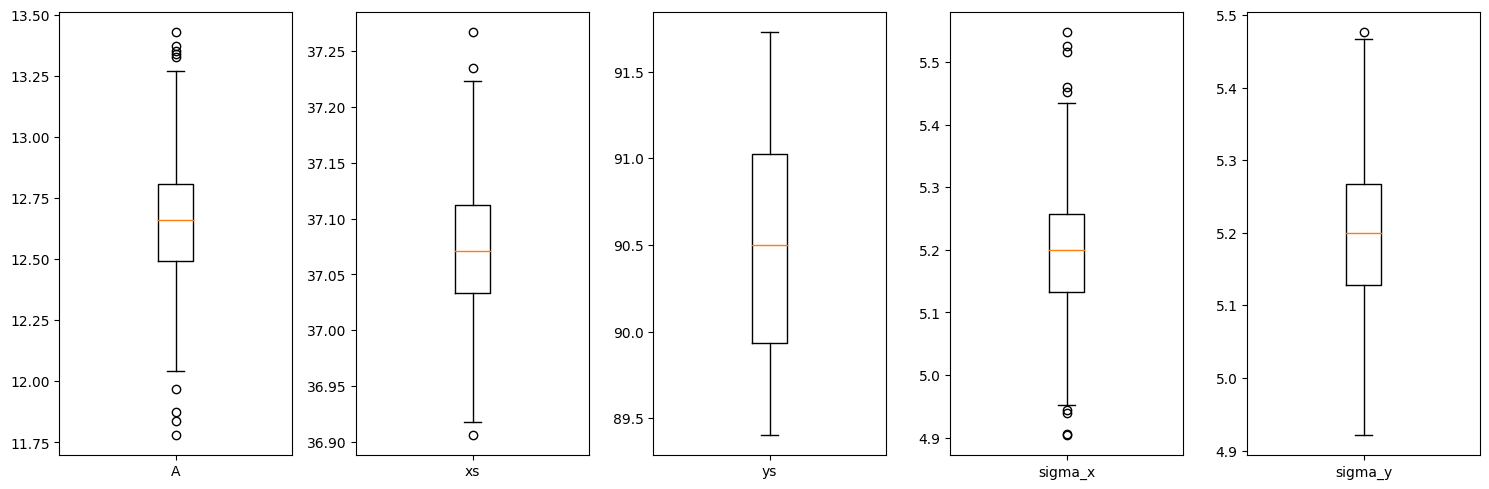

In [ ]:
fix, axs = plt.subplots(1, 5, figsize = (15, 5))
axs[0].boxplot(mean_amplitudes)
axs[1].boxplot(mean_xss)
axs[2].boxplot(mean_yss)
axs[3].boxplot(mean_dispersion_xss)
axs[4].boxplot(mean_dispersion_yss)
for i, label in enumerate(['A', 'xs', 'ys', 'sigma_x', 'sigma_y']):
  axs[i].set_xticklabels([label])
plt.tight_layout()

# Generation


In [ ]:
n_image = 0
# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Organize the tuples
params = list(zip(xs,
                  ys,
                  dispersion_x,
                  dispersion_y,
                  amplitude,
                  len(amplitude) * [0]))

In [ ]:
# Image size
width = mat['F_data'].shape[1]
length = mat['F_data'].shape[0]
x, y = generate_grid((0, width),
                     (0, length),
                     mat['F_data'].shape[1],
                     mat['F_data'].shape[0])

In [ ]:
# Generate gaussians
x, y, z = generate_distribution((0, width),
                                (0, length),
                                mat['F_data'].shape[1],
                                mat['F_data'].shape[0],
                                params)

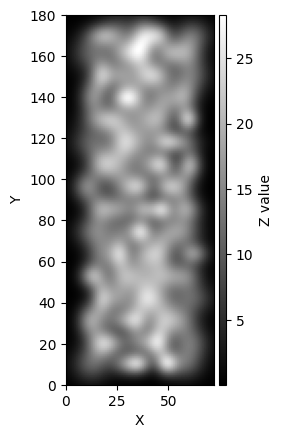

In [ ]:
fig, ax = plt.subplots()
plot_grayscale(x, y, z, ax = ax)

# [ESTIMATION PART I and II]
- Images: 400
- predict_T80kenji

## [ESTIMATION] Pipeline ppl_SCIKIT_GMM
- Processing using Scikit-image library
- Mean and covariances from GMM

In [ ]:
# Load data
n_image = 323

# Image - z intensities
image = [x, y, mat['F_data'][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

### Centers estimation

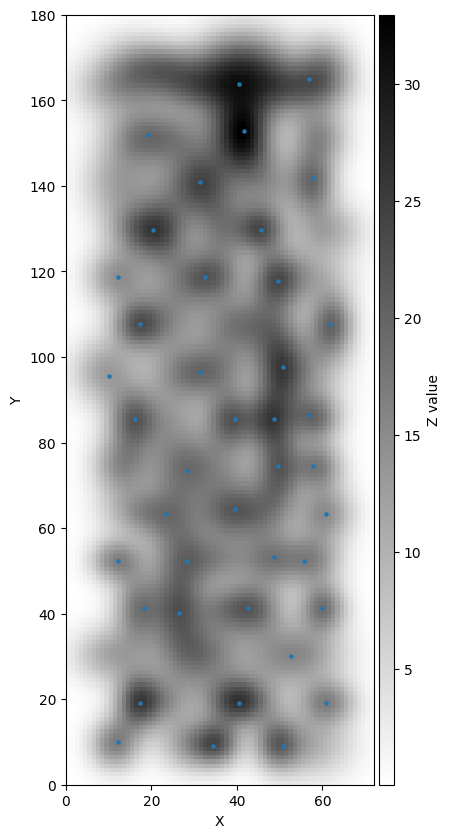

In [ ]:
# Find local maxima coordinates
coordinates = peak_local_max(image[2],
                             min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots(figsize = (15, 10))
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]],
           image[1][coordinates[:, 0], 0],
           s = 5)

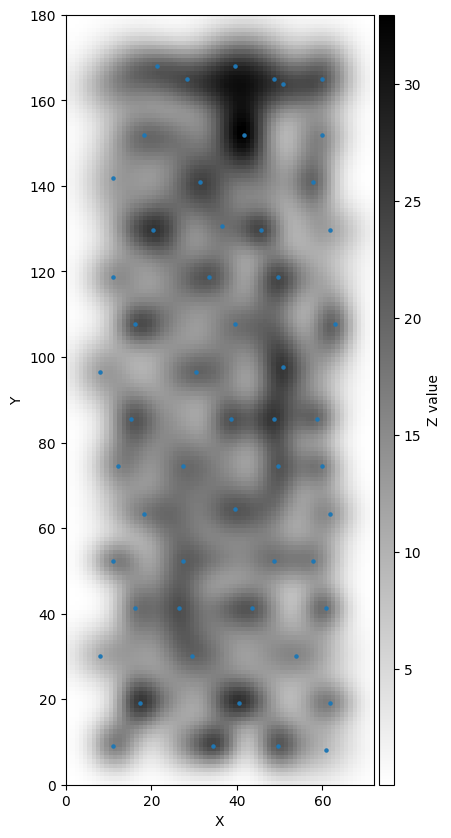

In [ ]:
# Find local maxima coordinates
z_laplace = laplace(image[2])
z_laplace[np.nonzero(z_laplace >= 0)] = 0
coordinates = peak_local_max(-1 * z_laplace, min_distance = 1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots(figsize = (15, 10))
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]],
           image[1][coordinates[:, 0], 0],
           s = 5)

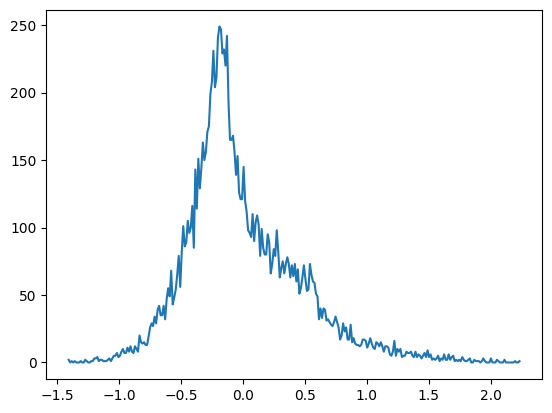

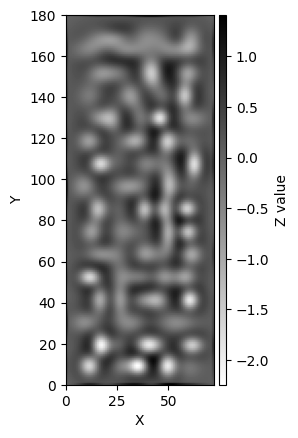

In [ ]:
# Thresholding laplacian
# histogram of values
histogram, bin_edges = np.histogram(-1 * laplace(image[2]), bins = 300)

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)

fig, ax = plt.subplots()
plot_grayscale(x, y, laplace(image[2]), ax)

estimate_parameters_gmm executed in 0.24471569061279297 seconds
ppl_fit_gaussians executed in 0.47582077980041504 seconds


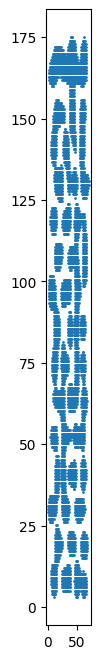

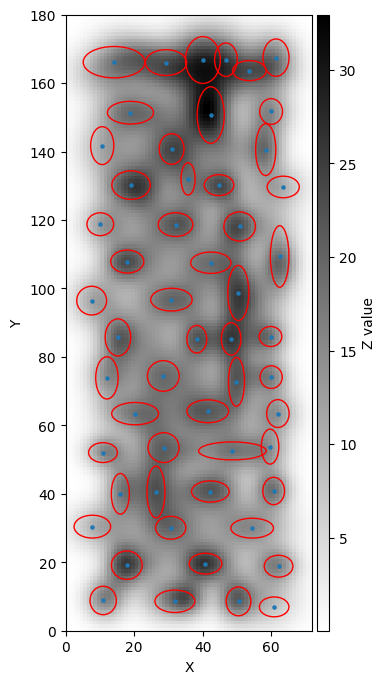

In [ ]:
# Estimate Gaussian - Final prediction
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = [(0, mat['F_data'].shape[1]),
                                                 (0, mat['F_data'].shape[2])],
                                 image_size = [mat['F_data'].shape[1],
                                               mat['F_data'].shape[2]],
                                 fig_size = (10, 8),
                                 plot = True,
                                 plot_points = True)

In [ ]:
labels_type = "Labelsv0_T80kenji_detect"
task = "detect"
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

Number of indentifiable Gaussians (center in the image): 80


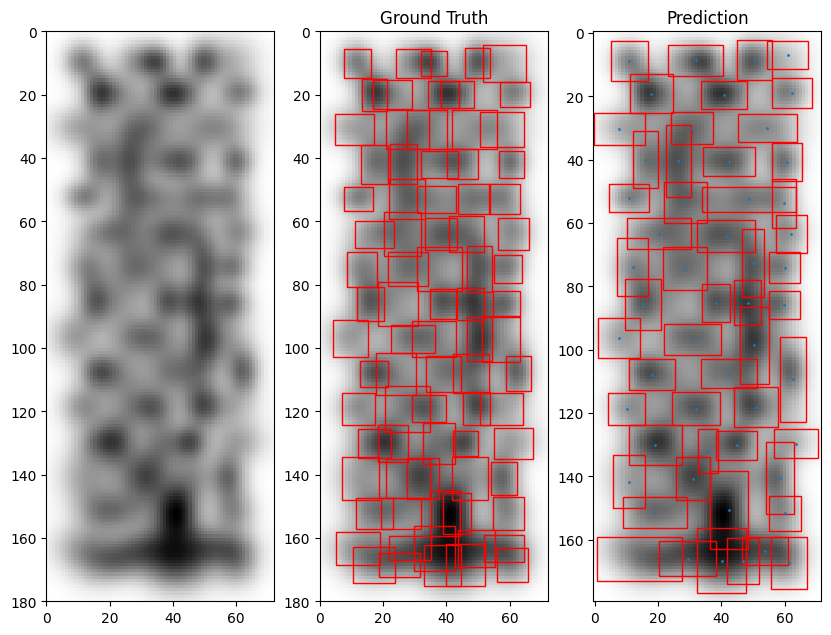

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize = (10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means = means/1000,
               covariances = covariances/10E5,
               ax = axs[2],
               beta = 3)
axs[2].set_title("Prediction")
axs[2].scatter(means[:,0], means[:, 1], s = 1)

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = task,
                   colorbar = False,
                   grid_width = CONFIG_RUN['image_ranges'][0][-1],
                   grid_length = CONFIG_RUN['image_ranges'][1][-1],
                   img_width = CONFIG_RUN['image_size'][0],
                   img_length = CONFIG_RUN['image_size'][1])
axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

### Error evaluation
- Dispersion_x in the mat file is equal to sqrt(2) * sigma_x, same for y direction

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
yolo_type = "YOLOv0_T80kenji_detect"
images_test = os.listdir(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{yolo_type}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(len(eval_images))
print(eval_images)

40
[208, 304, 262, 288, 77, 230, 45, 115, 172, 188, 93, 323, 371, 8, 285, 200, 383, 365, 297, 31, 28, 193, 322, 144, 286, 191, 155, 291, 109, 194, 97, 209, 310, 301, 70, 324, 4, 357, 57, 242]


In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - gmm' : [],
           'Number identifiable - gmm' : [],
           'Percentage - gmm' : [],
           'RMSE_cx - gmm' : [],
           'RMSE_cy - gmm' : [],
           'RMSE_c - gmm' : [],
           'RMSE_sigmax - gmm' : [],
           'RMSE_sigmay - gmm' : [],
           'RMSE_sigma - gmm' : [],
           'RMSE_amplitude - gmm': [],
           'MaxE_sigmax - gmm': [],
           'MaxE_sigmay - gmm': [],
           'MaxE_sigma - gmm': [],
           'RMSE_amplitude - gmm': [],
           'RMSEPixel - gmm': []}

for n_image in eval_images:
  print(n_image)
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       peak_method = 'laplace',
                                       estimation_method = "gmm",
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True,
                                       image_ranges = CONFIG_RUN['image_ranges'],
                                       image_size = CONFIG_RUN['image_size'])
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]

208
estimate_parameters_gmm executed in 0.28348779678344727 seconds
ppl_fit_gaussians executed in 0.29427456855773926 seconds
covariances [[[     3.7617           0]
  [          0      3.3807]]]
covariances true [[[     3.8035           0]
  [          0      3.8212]]]
304
estimate_parameters_gmm executed in 0.26227426528930664 seconds
ppl_fit_gaussians executed in 0.27162694931030273 seconds
covariances [[[     4.6075           0]
  [          0      3.3945]]]
covariances true [[[     3.9016           0]
  [          0      4.6955]]]
262
estimate_parameters_gmm executed in 0.2835540771484375 seconds
ppl_fit_gaussians executed in 0.29172539710998535 seconds
covariances [[[     4.0713           0]
  [          0      19.251]]]
covariances true [[[     6.3612           0]
  [          0      4.5062]]]
288
estimate_parameters_gmm executed in 0.2514472007751465 seconds
ppl_fit_gaussians executed in 0.5240890979766846 seconds
covariances [[[     3.9305           0]
  [          0      3.49

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean     std     max
Image                      203.22  112.45  383.00
Number identified - gmm     54.22    2.28   59.00
Number identifiable - gmm   80.00    0.00   80.00
Percentage - gmm            67.78    2.85   73.75
RMSE_cx - gmm                6.35    0.71    8.05
RMSE_cy - gmm                2.30    0.29    3.12
RMSE_c - gmm                 6.76    0.68    8.29
RMSE_sigmax - gmm           20.92    1.89   24.31
RMSE_sigmay - gmm           25.52    3.10   35.94
RMSE_sigma - gmm            33.07    2.99   42.60
RMSE_amplitude - gmm        45.62    2.83   50.13
MaxE_sigmax - gmm           76.73   33.08  209.99
MaxE_sigmay - gmm           91.82   50.37  327.20
MaxE_sigma - gmm           123.43   51.86  354.91
RMSEPixel - gmm              4.59    0.09    4.87

In [ ]:
pd.DataFrame.from_dict(results).round(2)

Image  Number identified - gmm  Number identifiable - gmm  \
0     208                       54                         80   
1     304                       58                         80   
2     262                       52                         80   
3     288                       55                         80   
4      77                       53                         80   
5     230                       52                         80   
6      45                       52                         80   
7     115                       56                         80   
8     172                       55                         80   
9     188                       50                         80   
10     93                       53                         80   
11    323                       54                         80   
12    371                       51                         80   
13      8                       52                         80   
14    285                       53                         80   
15    200                       56                         80   
16    383                       51                         80   
17    365                       55                         80   
18    297                       54                         80   
19     31                       58                         80   
20     28                       56                         80   
21    193                       53                         80   
22    322                       52                         80   
23    144                       53                         80   
24    286                       56                         80   
25    191                       57                         80   
26    155                       54                         80   
27    291                       58                         80   
28    109                       57                         80   
29    194                       54                         80   
30     97                       56                         80   
31    209                       53                         80   
32    310                       53                         80   
33    301                       56                         80   
34     70                       51                         80   
35    324                       54                         80   
36      4                       59                         80   
37    357                       51                         80   
38     57                       56                         80   
39    242                       56                         80   

    Percentage - gmm  RMSE_cx - gmm  RMSE_cy - gmm  RMSE_c - gmm  \
0              67.50           5.05           2.45          5.61   
1              72.50           5.56           2.76          6.20   
2              65.00           6.17           3.12          6.91   
3              68.75           6.53           2.33          6.94   
4              66.25           6.81           2.71          7.33   
5              65.00           6.90           2.57          7.36   
6              65.00           5.38           2.25          5.84   
7              70.00           5.64           2.22          6.07   
8              68.75           7.26           2.50          7.67   
9              62.50           6.96           2.09          7.27   
10             66.25           5.92           2.04          6.27   
11             67.50           5.88           2.59          6.42   
12             63.75           5.54           2.42          6.05   
13             65.00           6.97           2.21          7.31   
14             66.25           7.20           2.54          7.63   
15             70.00           6.77           2.67          7.28   
16             63.75           5.71           2.35          6.17   
17             68.75           6.69           2.05          6.99   
18             67.50           5.98           

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/gaussian_{n_image}.png"

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {"GMM - random state 13 - 400 images"}\n
                 id_images evaluated: {eval_images}""",
                 name = "T80kenjiGMM")

#### Total error

In [ ]:
# Computing error
gaussians = list(zip(means, covariances, amplitudes))

# Generate image from Gaussians and compute MSE
generated_image = sum_gaussians(x, y, gaussians)
mse = compute_mse(image[2], generated_image)

## [ESTIMATION] Pipeline ppl_Yolo DS-IE

In [41]:
n_image = 109

labels_type = "Labelsv0_T80kenji_detect"
task = "detect"
model_name = "YOLOv0_E12_detect"
date_train = "2023-08-21_13-57-46"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

In [42]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [(float(x),
          float(y)) for
          x,y in zip(results[0].boxes.xywhn[:, 0] * CONFIG_RUN['image_size'][0],
                     results[0].boxes.xywhn[:, 1]  * CONFIG_RUN['image_size'][1])]


0: 640x256 91 gaussians, 569.0ms
Speed: 2.0ms preprocess, 569.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


TypeError: ignored

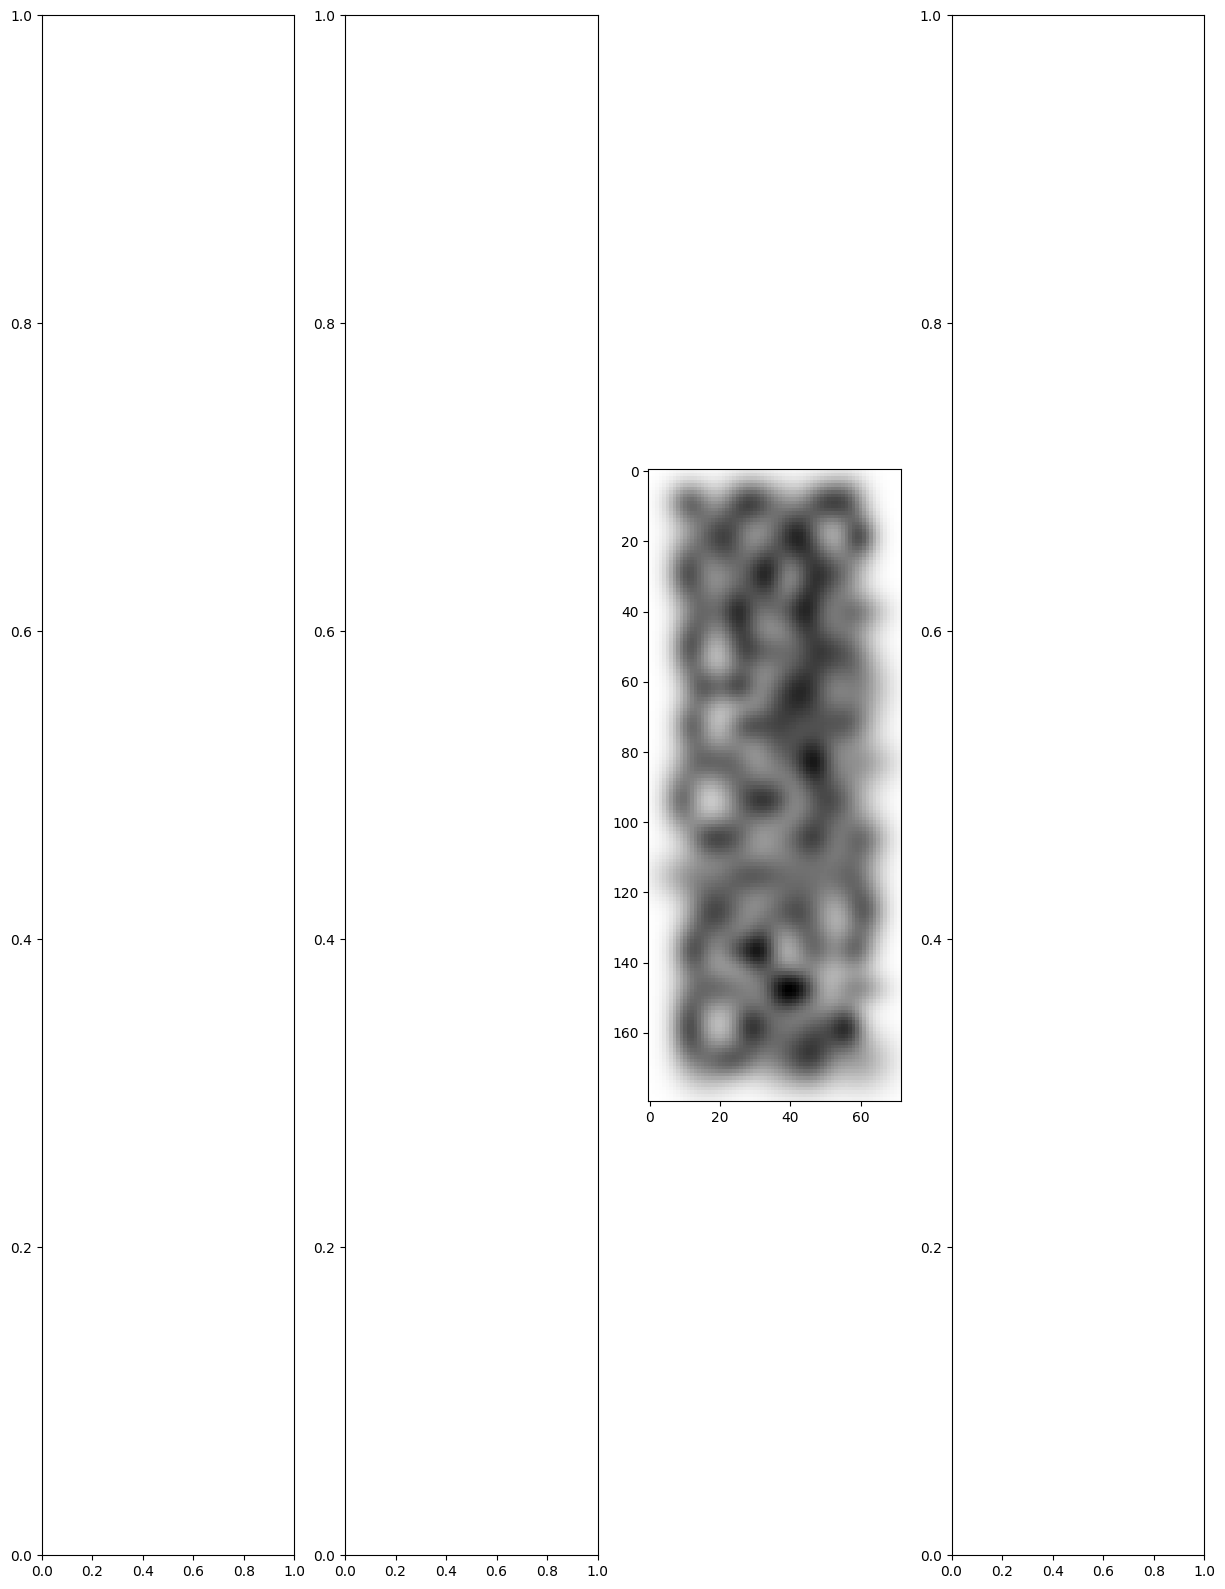

In [34]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize = (15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes_gmm(means = means/1000,
               covariances = covariances/10E5,
               ax = axs[2],
               beta = 3,
               edge_color = '#0343DF')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:,0], means[:, 1], s = 1)
# axs[3].axis('off')
axs[2].set_xlim(0, CONFIG_RUN['image_size'][0])
axs[2].set_ylim(0, CONFIG_RUN['image_size'][1])


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes,
           axs[3],
           edge_color = 'g')
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means_yolo)[:,0], np.array(means_yolo)[:, 1], s = 1)
# axs[2].axis('off')
axs[3].set_xlim(0, CONFIG_RUN['image_size'][0])
axs[3].set_ylim(0, CONFIG_RUN['image_size'][1])

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = task,
                   colorbar = False,
                   plot_centers = True,
                   grid_width = CONFIG_RUN['image_ranges'][0][-1],
                   grid_length = CONFIG_RUN['image_ranges'][1][-1],
                   img_width = CONFIG_RUN['image_size'][0],
                   img_length = CONFIG_RUN['image_size'][1])
# axs[1].axis('off')
axs[1].set_xlim(0, CONFIG_RUN['image_size'][0])
axs[1].set_ylim(0, CONFIG_RUN['image_size'][1])
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, CONFIG_RUN['image_size'][0])
axs[0].set_ylim(0, CONFIG_RUN['image_size'][1])


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
yolo_type = "YOLOv0_T80kenji_detect"
images_test = os.listdir(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{yolo_type}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[208, 304, 262, 288, 77, 230, 45, 115, 172, 188, 93, 323, 371, 8, 285, 200, 383, 365, 297, 31, 28, 193, 322, 144, 286, 191, 155, 291, 109, 194, 97, 209, 310, 301, 70, 324, 4, 357, 57, 242]


In [ ]:
# Load our custom model
model_name = "YOLOv0_E12_detect"
task = "detect"
date_train = "2023-08-21_13-57-46"
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO' : [],
           'Number identifiable - YOLO' : [],
           'Percentage - YOLO' : [],
           'RMSE_cx - YOLO' : [],
           'RMSE_cy - YOLO' : [],
           'RMSE_c - YOLO' : [],
           'RMSE_sigmax - YOLO' : [],
           'RMSE_sigmay - YOLO' : [],
           'RMSE_sigma - YOLO' : [],
           'MaxE_sigmax - YOLO': [],
           'MaxE_sigmay - YOLO': [],
           'MaxE_sigma - YOLO': [],
           'RMSE_amplitude - YOLO': [],
           'RMSEPixel - YOLO': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True,
                                       image_ranges = CONFIG_RUN['image_ranges'],
                                       image_size = CONFIG_RUN['image_size'])
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 88 gaussians, 373.1ms
Speed: 1.3ms preprocess, 373.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.8104           0]
  [          0      5.8108]]]
covariances true [[[     5.3991           0]
  [          0      5.3336]]]



0: 640x256 92 gaussians, 536.7ms
Speed: 1.7ms preprocess, 536.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[      8.157           0]
  [          0      5.7845]]]
covariances true [[[     5.3992           0]
  [          0      3.9359]]]



0: 640x256 78 gaussians, 1192.6ms
Speed: 1.1ms preprocess, 1192.6ms inference, 14.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.5336           0]
  [          0      7.0598]]]
covariances true [[[     5.8366           0]
  [          0      5.4095]]]



0: 640x256 72 gaussians, 411.6ms
Speed: 1.2ms preprocess, 411.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.7912           0]
  [          0      5.4697]]]
covariances true [[[     5.3771           0]
  [          0       3.654]]]



0: 640x256 87 gaussians, 343.4ms
Speed: 1.7ms preprocess, 343.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.2322           0]
  [          0      5.7359]]]
covariances true [[[     5.5201           0]
  [          0      3.8042]]]



0: 640x256 91 gaussians, 273.2ms
Speed: 1.3ms preprocess, 273.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.1826           0]
  [          0      5.7682]]]
covariances true [[[      5.442           0]
  [          0      4.5346]]]



0: 640x256 79 gaussians, 183.4ms
Speed: 5.6ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.7738           0]
  [          0      5.2778]]]
covariances true [[[     5.5298           0]
  [          0      3.6782]]]



0: 640x256 90 gaussians, 176.5ms
Speed: 2.5ms preprocess, 176.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.3068           0]
  [          0      5.6921]]]
covariances true [[[      5.109           0]
  [          0      3.9206]]]



0: 640x256 91 gaussians, 179.9ms
Speed: 1.2ms preprocess, 179.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.7295           0]
  [          0      6.2175]]]
covariances true [[[     4.6205           0]
  [          0      4.1786]]]



0: 640x256 88 gaussians, 178.5ms
Speed: 1.6ms preprocess, 178.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[      8.068           0]
  [          0      6.0308]]]
covariances true [[[     5.2537           0]
  [          0      4.1029]]]



0: 640x256 87 gaussians, 181.3ms
Speed: 7.6ms preprocess, 181.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     7.2979           0]
  [          0      6.1802]]]
covariances true [[[     5.1254           0]
  [          0      4.3112]]]


0: 640x256 91 gaussians, 186.1ms
Speed: 1.1ms preprocess, 186.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.4053           0]
  [          0      5.3382]]]
covariances true [[[     4.2379           0]
  [          0      3.6142]]]



0: 640x256 88 gaussians, 173.8ms
Speed: 2.0ms preprocess, 173.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.7239           0]
  [          0      5.2335]]]
covariances true [[[     5.4315           0]
  [          0      3.6159]]]



0: 640x256 83 gaussians, 193.0ms
Speed: 1.5ms preprocess, 193.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     10.221           0]
  [          0      6.2099]]]
covariances true [[[     6.2112           0]
  [          0      4.1014]]]



0: 640x256 87 gaussians, 179.7ms
Speed: 1.9ms preprocess, 179.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.1263           0]
  [          0      6.1469]]]
covariances true [[[     5.7158           0]
  [          0       4.362]]]



0: 640x256 84 gaussians, 171.7ms
Speed: 1.6ms preprocess, 171.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.7909           0]
  [          0      6.1112]]]
covariances true [[[     6.0482           0]
  [          0      4.2614]]]



0: 640x256 89 gaussians, 179.7ms
Speed: 2.1ms preprocess, 179.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.1559           0]
  [          0      5.9759]]]
covariances true [[[     5.7356           0]
  [          0      3.8975]]]



0: 640x256 91 gaussians, 184.5ms
Speed: 1.4ms preprocess, 184.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[      8.643           0]
  [          0      6.1916]]]
covariances true [[[     4.7311           0]
  [          0      4.1403]]]



0: 640x256 93 gaussians, 182.9ms
Speed: 1.2ms preprocess, 182.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     11.189           0]
  [          0      5.3595]]]
covariances true [[[     6.3647           0]
  [          0      4.6011]]]



0: 640x256 107 gaussians, 177.0ms
Speed: 4.1ms preprocess, 177.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.1706           0]
  [          0      6.3047]]]
covariances true [[[     5.5911           0]
  [          0      4.5893]]]



0: 640x256 88 gaussians, 182.8ms
Speed: 1.7ms preprocess, 182.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.9572           0]
  [          0      6.1164]]]
covariances true [[[     4.9467           0]
  [          0      4.3504]]]



0: 640x256 87 gaussians, 205.7ms
Speed: 3.5ms preprocess, 205.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.6858           0]
  [          0       5.316]]]
covariances true [[[     5.2259           0]
  [          0      3.6808]]]



0: 640x256 98 gaussians, 246.2ms
Speed: 1.1ms preprocess, 246.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     10.154           0]
  [          0      6.1785]]]
covariances true [[[     5.0186           0]
  [          0      3.8209]]]



0: 640x256 85 gaussians, 255.1ms
Speed: 3.1ms preprocess, 255.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.5492           0]
  [          0      5.7806]]]
covariances true [[[     5.5562           0]
  [          0      4.1562]]]



0: 640x256 86 gaussians, 237.7ms
Speed: 1.2ms preprocess, 237.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.4809           0]
  [          0      5.3339]]]
covariances true [[[     5.2638           0]
  [          0      3.6291]]]



0: 640x256 85 gaussians, 247.5ms
Speed: 1.3ms preprocess, 247.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.4258           0]
  [          0      5.8276]]]
covariances true [[[     5.2157           0]
  [          0      4.2721]]]



0: 640x256 92 gaussians, 171.7ms
Speed: 1.0ms preprocess, 171.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.9835           0]
  [          0      6.4455]]]
covariances true [[[     5.6168           0]
  [          0      5.6125]]]



0: 640x256 76 gaussians, 174.7ms
Speed: 0.9ms preprocess, 174.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.2705           0]
  [          0      5.4942]]]
covariances true [[[     4.2782           0]
  [          0      3.6208]]]



0: 640x256 91 gaussians, 174.0ms
Speed: 1.2ms preprocess, 174.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.8811           0]
  [          0      6.7322]]]
covariances true [[[     4.9199           0]
  [          0       4.536]]]



0: 640x256 78 gaussians, 169.2ms
Speed: 1.2ms preprocess, 169.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.7891           0]
  [          0      5.4017]]]
covariances true [[[      5.504           0]
  [          0      3.7813]]]



0: 640x256 80 gaussians, 182.7ms
Speed: 1.6ms preprocess, 182.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.9819           0]
  [          0      5.5732]]]
covariances true [[[     6.5822           0]
  [          0      3.7686]]]



0: 640x256 102 gaussians, 182.8ms
Speed: 1.8ms preprocess, 182.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.6116           0]
  [          0      5.7899]]]
covariances true [[[     5.6826           0]
  [          0      5.3656]]]



0: 640x256 84 gaussians, 188.1ms
Speed: 1.5ms preprocess, 188.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.7707           0]
  [          0      5.6576]]]
covariances true [[[     4.7404           0]
  [          0      3.9342]]]



0: 640x256 85 gaussians, 177.1ms
Speed: 1.6ms preprocess, 177.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.9386           0]
  [          0      5.9892]]]
covariances true [[[     5.2065           0]
  [          0      4.4869]]]



0: 640x256 87 gaussians, 180.3ms
Speed: 1.5ms preprocess, 180.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[      7.447           0]
  [          0      5.5283]]]
covariances true [[[     5.1142           0]
  [          0      3.9174]]]



0: 640x256 81 gaussians, 179.5ms
Speed: 1.1ms preprocess, 179.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     7.1671           0]
  [          0      5.5819]]]
covariances true [[[     4.7364           0]
  [          0      3.7523]]]



0: 640x256 85 gaussians, 177.5ms
Speed: 1.0ms preprocess, 177.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.2515           0]
  [          0      5.7272]]]
covariances true [[[     5.3038           0]
  [          0      3.8928]]]



0: 640x256 88 gaussians, 184.7ms
Speed: 2.0ms preprocess, 184.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     6.6107           0]
  [          0      5.4424]]]
covariances true [[[     4.6746           0]
  [          0      3.7125]]]



0: 640x256 97 gaussians, 173.0ms
Speed: 1.5ms preprocess, 173.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     9.1738           0]
  [          0      5.3867]]]
covariances true [[[     6.6235           0]
  [          0      3.6998]]]



0: 640x256 87 gaussians, 168.1ms
Speed: 1.2ms preprocess, 168.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     8.6178           0]
  [          0      5.8301]]]
covariances true [[[     4.9941           0]
  [          0      5.5869]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean     std     max
Image                       203.22  112.45  383.00
Number identified - YOLO     87.45    6.66  107.00
Number identifiable - YOLO   80.00    0.00   80.00
Percentage - YOLO           109.31    8.33  133.75
RMSE_cx - YOLO                8.39    1.27   11.49
RMSE_cy - YOLO                6.20    2.57   15.89
RMSE_c - YOLO                10.58    2.24   18.15
RMSE_sigmax - YOLO           52.83    3.40   62.09
RMSE_sigmay - YOLO           22.63    2.09   27.62
RMSE_sigma - YOLO            57.53    3.10   67.50
MaxE_sigmax - YOLO          152.13   29.31  233.90
MaxE_sigmay - YOLO           67.18    9.87   90.56
MaxE_sigma - YOLO           166.87   27.66  244.24
RMSE_amplitude - YOLO        60.96    4.13   69.92
RMSEPixel - YOLO             14.70    2.99   20.76

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - YOLO  Number identifiable - YOLO  \
36      4                        85                          80   
13      8                        83                          80   
20     28                        88                          80   
19     31                       107                          80   
6      45                        79                          80   
38     57                        97                          80   
34     70                        87                          80   
4      77                        87                          80   
10     93                        87                          80   
30     97                        80                          80   
28    109                        91                          80   
7     115                        90                          80   
23    144                        85                          80   
26    155                        92                          80   
8     172                        91                          80   
9     188                        88                          80   
25    191                        85                          80   
21    193                        87                          80   
29    194                        78                          80   
15    200                        84                          80   
0     208                        88                          80   
31    209                       102                          80   
5     230                        91                          80   
39    242                        87                          80   
2     262                        78                          80   
14    285                        87                          80   
24    286                        86                          80   
3     288                        72                          80   
27    291                        76                          80   
18    297                        93                          80   
33    301                        85                          80   
1     304                        92                          80   
32    310                        84                          80   
22    322                        98                          80   
11    323                        91                          80   
35    324                        81                          80   
37    357                        88                          80   
17    365                        91                          80   
12    371                        88                          80   
16    383                        89                          80   

    Percentage - YOLO  RMSE_cx - YOLO  RMSE_cy - YOLO  RMSE_c - YOLO  \
36             106.25            7.80            5.29           9.43   
13             103.75            8.46            5.50          10.09   
20             110.00            7.40            4.47           8.64   
19             133.75            5.31            3.97           6.62   
6               98.75            8.73            6.91          11.13   
38             121.25            7.52            4.50           8.76   
34             108.75            8.75            6.56          10.94   
4              108.75            7.34            6.05           9.52   
10             108.75            9.06            7.61          11.83   
30             100.00            8.77           15.89          18.15   
28             113.75            6.81            5.10           8.51   
7              112.50            7.54            3.99           8.53   
23             106.25            7.45            6.31           9.76   
26             115.00            7.42            5.01           8.95   
8              113.75            8.17            4.94           9.54   
9              110.00           11.49            4.86          12.47   
25             106.25           

## [ESTIMATION] Pipeline ppl_Yolo - Retrained

### Gaussians labelling for Yolo

In [ ]:
"""Generating labels - Here is the labelling of the images,
not the structuring in folders
"""
labels_type = "Labelsv0_T80kenji_detect"
ppl_label_YOLOv0(mat['F_data'],
                 mat['Fit_flux'],
                 f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}",
                 remove_out_of_image = True,
                 task = "detect",
                 n_contour_points = None,
                 octagon_pol = False,
                 image_ranges = CONFIG_RUN['image_ranges'],
                 image_size = CONFIG_RUN['image_size'])

Number of indentifiable Gaussians (center in the image): 80


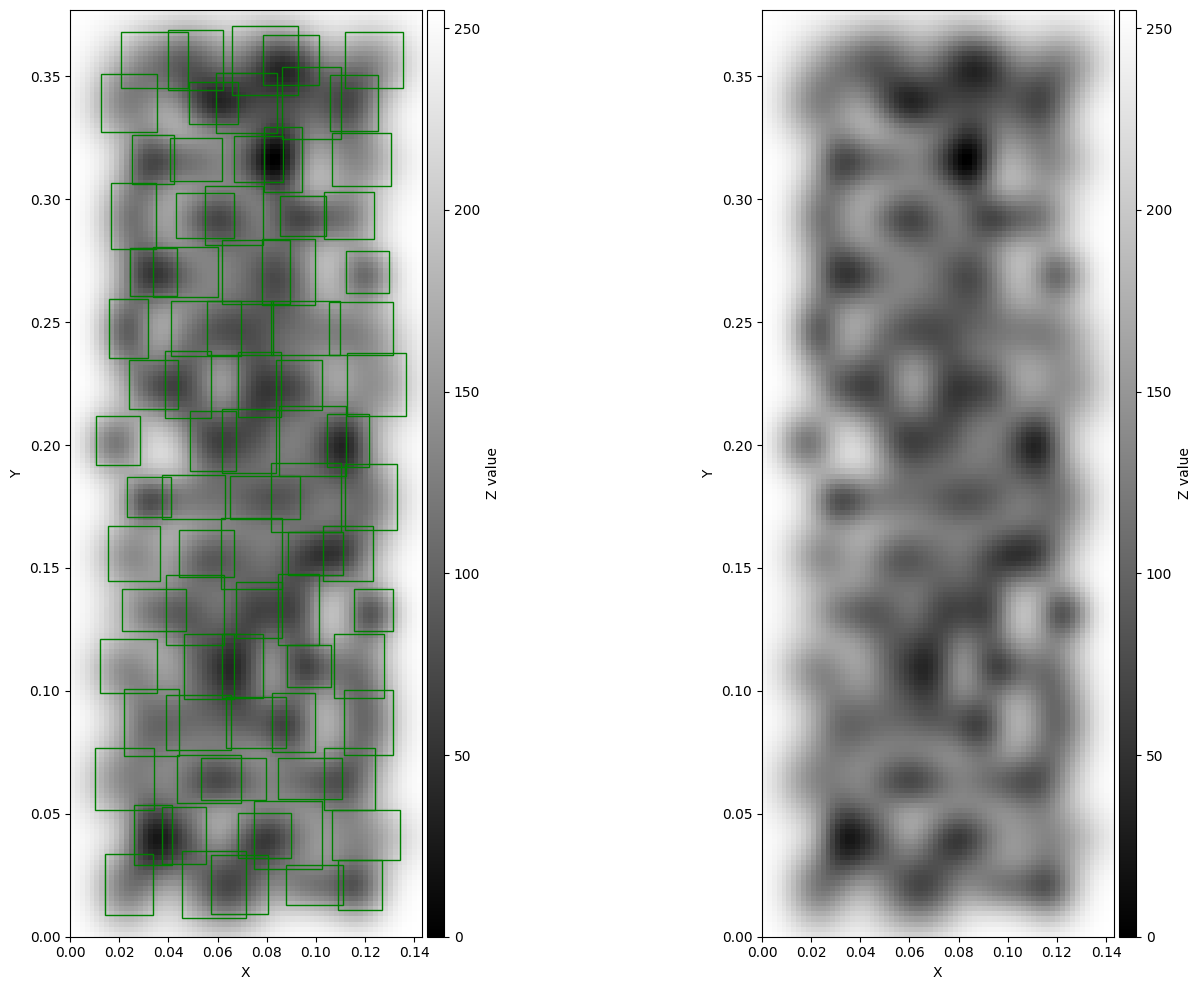

In [ ]:
# Plot ground truth labels
n_image = 313
labels_type = "Labelsv0_T80kenji_detect"
task = "detect"
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

fig, axs = plt.subplots(1, 2, figsize = (15, 10))
x, y, z = gaussians_labelled(image_path,
                            label_path,
                            axs[0],
                            task = task)

plot_grayscale(x, y, z, ax = axs[1])
fig.tight_layout()

In [ ]:
# Labels problem in Yolo
lines = load_label(label_path).split("\n")
# Step 2: Split each line into columns using spaces as the separator
labels = [line.split() for line in lines]
df_labels = pd.DataFrame(labels)

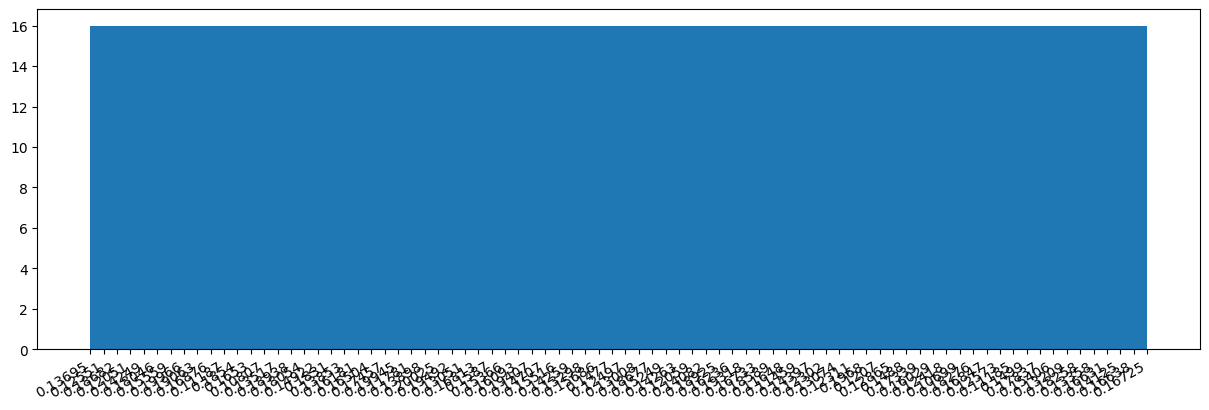

In [ ]:
# In the image distribution of dispersion in x
fig, ax = plt.subplots(figsize = (15, 5))
ax.hist(df_labels[[3]], bins = 5)
fig.autofmt_xdate()

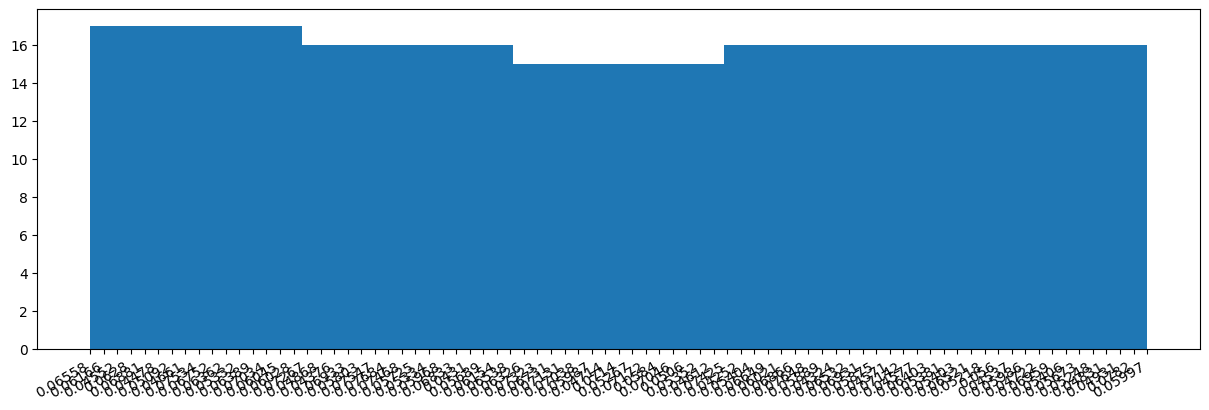

In [ ]:
# In the image distribution of dispersion in y
fig, ax = plt.subplots(figsize = (15, 5))
ax.hist(df_labels[[4]], bins = 5)
fig.autofmt_xdate()

### Yolo structure - distribute images in folder

In [ ]:
"""
Image distribution for YoloV0
  - 400 images from T80kenji distributed
  - Labels without  gaussians with center out of the image
"""
labels_type = "Labelsv0_T80kenji_detect"
yolo_type = "YOLOv0_T80kenji_detect"
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{yolo_type}/datasets/"
images_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/"
labels_folder= f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/"
range_images = list(range(0, 400))
proportions = {'train': 0.7, 'val': 0.2, 'test': 0.1}

ppl_distribute_images_yolo(images_folder,
                           labels_folder,
                           yolo_folder,
                           range_images,
                           proportions)

In [ ]:
# Config Yolo model to train
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{yolo_type}/"
yaml_content = (f'''
                train: {os.path.join(yolo_folder, "datasets/train/images")}
                val: {os.path.join(yolo_folder, "datasets/val/images")}
                test: {os.path.join(yolo_folder, "datasets/test/images")}
                names: ['gaussian']
                ''')

with open(os.path.join(yolo_folder,'data.yaml'), 'w') as f:
    f.write(yaml_content)

### Training model - YOLOv0_E12

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [ ]:
# Load nano model
model = YOLO("yolov8s.pt") # "yolov8s-seg.pt"

100%|██████████| 21.5M/21.5M [00:00<00:00, 58.9MB/s]


In [ ]:
# Train
model_name = "YOLOv0_E12_detect"
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}"
results = model.train(
        device = 0, # "cpu"
        batch = -1,
        patience = 100,
        task = "detect",
        data = os.path.join(yolo_folder,'data.yaml'),
        epochs = 100,
    )

New https://pypi.org/project/ultralytics/8.0.158 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E12_detect/data.yaml, epochs=100, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None

In [ ]:
# Copy results
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
shutil.copytree(Path("/content/runs/"), Path(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{timestamp}"))

PosixPath('/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E12_detect/runs/2023-08-21_11-28-17')

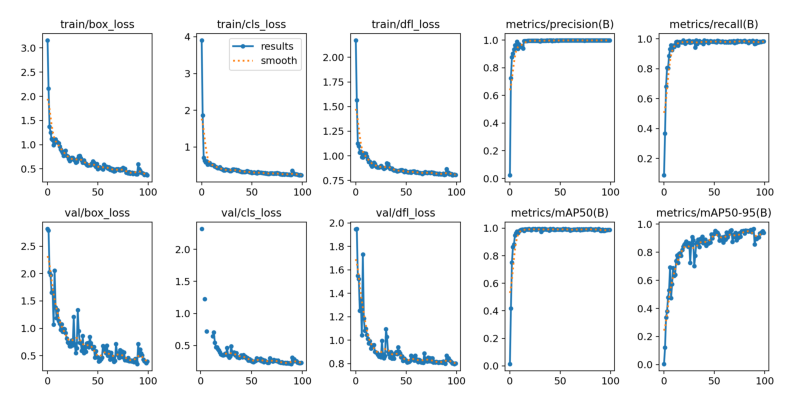

In [ ]:
task = "detect"
plotting.plot_results(f'/content/runs/{task}/train/results.csv')
image = Image.open(f'/content/runs/{task}/train/results.png')
fig = plt.figure(figsize = (10, 8))
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

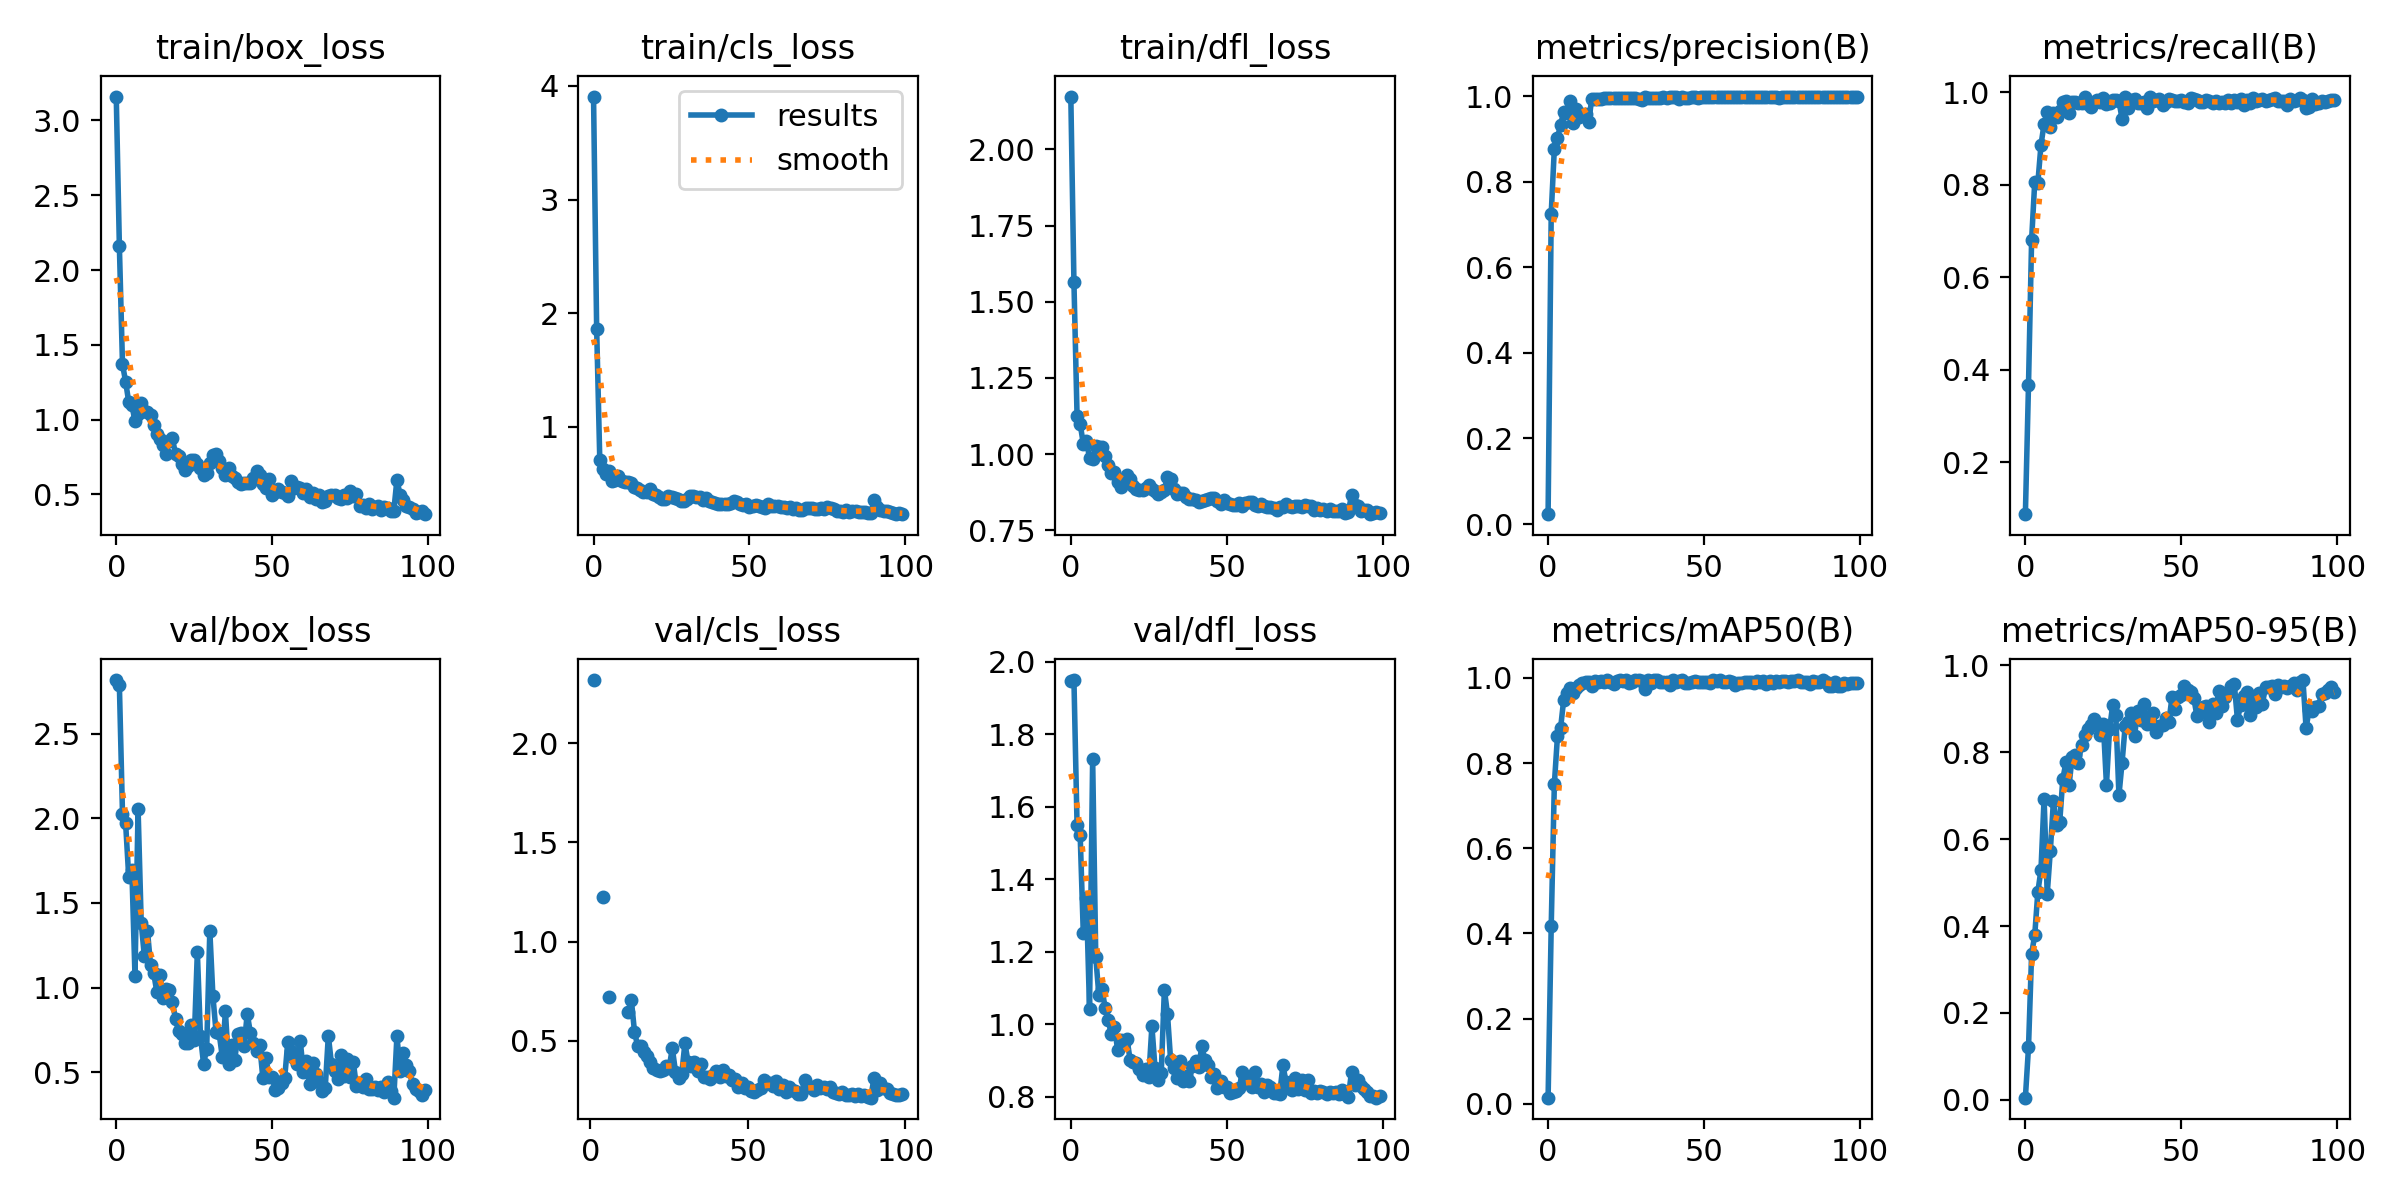

In [ ]:
image

### Training model - YOLOv0_T80kenji - 200 epochs

In [ ]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [ ]:
# Load nano model
model = YOLO("yolov8s.pt") # "yolov8s-seg.pt"

100%|██████████| 21.5M/21.5M [00:00<00:00, 381MB/s]


In [ ]:
# Train
model_name = "YOLOv0_T80kenji_detect"
yolo_folder = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}"
results = model.train(
        device = 0, # "cpu"
        batch = -1,
        patience = 100,
        task = "detect",
        data = os.path.join(yolo_folder,'data.yaml'),
        epochs = 200,
    )

New https://pypi.org/project/ultralytics/8.0.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.154 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_T80kenji_detect/data.yaml, epochs=200, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width

In [ ]:
# Copy results
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
shutil.copytree(Path("/content/runs/"), Path(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{timestamp}"))

In [ ]:
task = "detect"
plotting.plot_results(f'/content/runs/{task}/train/results.csv')
image = Image.open(f'/content/runs/{task}/train/results.png')
fig = plt.figure(figsize = (10, 8))
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [ ]:
image

### Predict with custom model - YOLOv0

In [24]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models")

['YOLOv0_detect',
 'YOLOv0_E2_detect',
 'YOLOv0_E3_detect',
 'YOLOv0_E12_detect',
 'YOLOv0_E4_detect',
 'Archive',
 'YOLOv0_E1_detect',
 'YOLOv0_T80kenji_detect']

In [25]:
os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_T80kenji_detect/datasets/test/images/")

['gaussian_208.png',
 'gaussian_304.png',
 'gaussian_262.png',
 'gaussian_288.png',
 'gaussian_77.png',
 'gaussian_230.png',
 'gaussian_45.png',
 'gaussian_115.png',
 'gaussian_172.png',
 'gaussian_188.png',
 'gaussian_93.png',
 'gaussian_323.png',
 'gaussian_371.png',
 'gaussian_8.png',
 'gaussian_285.png',
 'gaussian_200.png',
 'gaussian_383.png',
 'gaussian_365.png',
 'gaussian_297.png',
 'gaussian_31.png',
 'gaussian_28.png',
 'gaussian_193.png',
 'gaussian_322.png',
 'gaussian_144.png',
 'gaussian_286.png',
 'gaussian_191.png',
 'gaussian_155.png',
 'gaussian_291.png',
 'gaussian_109.png',
 'gaussian_194.png',
 'gaussian_97.png',
 'gaussian_209.png',
 'gaussian_310.png',
 'gaussian_301.png',
 'gaussian_70.png',
 'gaussian_324.png',
 'gaussian_4.png',
 'gaussian_357.png',
 'gaussian_57.png',
 'gaussian_242.png']

In [43]:
n_image = 109

labels_type = "Labelsv0_T80kenji_detect"
task = "detect"
model_name = "YOLOv0_T80kenji_detect"
date_train = "2023-09-04_11-19-43"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

In [44]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes_new = results[0].boxes.xyxy

# Centers
means = [(float(x),
          float(y)) for
          x,y in zip(results[0].boxes.xywhn[:, 0] * CONFIG_RUN['image_size'][0],
                     results[0].boxes.xywhn[:, 1]  * CONFIG_RUN['image_size'][1])]


0: 640x256 80 gaussians, 1497.2ms
Speed: 1.8ms preprocess, 1497.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


Number of indentifiable Gaussians (center in the image): 80


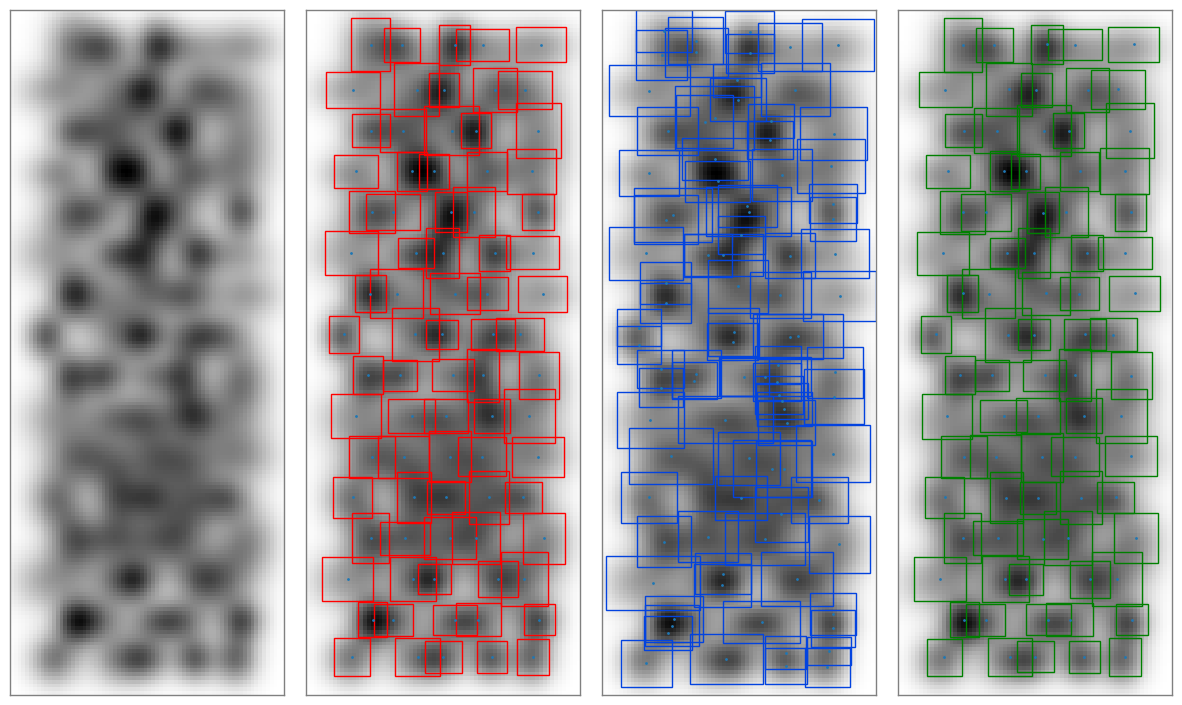

In [45]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize = (15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes(tensor_boxes,
           axs[2],
           edge_color = '#0343DF')
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(np.array(means_yolo)[:,0], np.array(means_yolo)[:, 1], s = 1)
# axs[3].axis('off')
axs[2].set_xlim(0, CONFIG_RUN['image_size'][0])
axs[2].set_ylim(0, CONFIG_RUN['image_size'][1])


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes_new,
           axs[3],
           edge_color = 'g')
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means)[:,0], np.array(means)[:, 1], s = 1)
# axs[2].axis('off')
axs[3].set_xlim(0, CONFIG_RUN['image_size'][0])
axs[3].set_ylim(0, CONFIG_RUN['image_size'][1])

#axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(image_path,
                   label_path,
                   axs[1],
                   task = task,
                   colorbar = False,
                   plot_centers = True,
                   grid_width = CONFIG_RUN['image_ranges'][0][-1],
                   grid_length = CONFIG_RUN['image_ranges'][1][-1],
                   img_width = CONFIG_RUN['image_size'][0],
                   img_length = CONFIG_RUN['image_size'][1])
# axs[1].axis('off')
axs[1].set_xlim(0, CONFIG_RUN['image_size'][0])
axs[1].set_ylim(0, CONFIG_RUN['image_size'][1])
#axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar = False, ax = axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, CONFIG_RUN['image_size'][0])
axs[0].set_ylim(0, CONFIG_RUN['image_size'][1])


for ax in axs:
  ax.xaxis.label.set_text("")
  ax.yaxis.label.set_text("")

  ax.set_xticks([])
  ax.set_yticks([])
  # Change the color of the axis spines (borders)
  for spine in ax.spines.values():
      spine.set_edgecolor('gray')
      spine.set_linewidth(1)

plt.subplots_adjust(wspace= 0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
yolo_type = "YOLOv0_T80kenji_detect"
images_test = os.listdir(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{yolo_type}/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO
print(eval_images)
print(len(eval_images))

[208, 304, 262, 288, 77, 230, 45, 115, 172, 188, 93, 323, 371, 8, 285, 200, 383, 365, 297, 31, 28, 193, 322, 144, 286, 191, 155, 291, 109, 194, 97, 209, 310, 301, 70, 324, 4, 357, 57, 242]
40


In [ ]:
# Load our custom model
model_name = "YOLOv0_T80kenji_detect"
task = "detect"
date_train = "2023-09-04_11-19-43"
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO' : [],
           'Number identifiable - YOLO' : [],
           'Percentage - YOLO' : [],
           'RMSE_cx - YOLO' : [],
           'RMSE_cy - YOLO' : [],
           'RMSE_c - YOLO' : [],
           'RMSE_sigmax - YOLO' : [],
           'RMSE_sigmay - YOLO' : [],
           'RMSE_sigma - YOLO' : [],
           'MaxE_sigmax - YOLO': [],
           'MaxE_sigmay - YOLO': [],
           'MaxE_sigma - YOLO': [],
           'RMSE_amplitude - YOLO': [],
           'RMSEPixel - YOLO': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True,
                                       image_ranges = CONFIG_RUN['image_ranges'],
                                       image_size = CONFIG_RUN['image_size'])
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 80 gaussians, 196.0ms
Speed: 1.5ms preprocess, 196.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.7139           0]
  [          0      4.7234]]]
covariances true [[[     3.6841           0]
  [          0       4.709]]]


0: 640x256 80 gaussians, 179.1ms
Speed: 1.4ms preprocess, 179.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8604           0]
  [          0      4.4676]]]
covariances true [[[     3.8343           0]
  [          0      4.5156]]]


0: 640x256 80 gaussians, 181.4ms
Speed: 1.6ms preprocess, 181.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.0351           0]
  [          0      6.2795]]]
covariances true [[[     4.0542           0]
  [          0      6.0914]]]


0: 640x256 80 gaussians, 182.9ms
Speed: 1.5ms preprocess, 182.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.7345           0]
  [          0      4.7311]]]
covariances true [[[     4.6503           0]
  [          0       4.771]]]


0: 640x256 80 gaussians, 173.2ms
Speed: 3.9ms preprocess, 173.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8546           0]
  [          0      5.7056]]]
covariances true [[[     3.8296           0]
  [          0      5.7002]]]


0: 640x256 80 gaussians, 174.8ms
Speed: 1.2ms preprocess, 174.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[      4.276           0]
  [          0      5.3679]]]
covariances true [[[     4.3167           0]
  [          0      5.4438]]]


0: 640x256 80 gaussians, 175.8ms
Speed: 1.2ms preprocess, 175.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6877           0]
  [          0      4.9438]]]
covariances true [[[     3.7386           0]
  [          0      5.0817]]]


0: 640x256 80 gaussians, 170.9ms
Speed: 1.0ms preprocess, 170.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.1811           0]
  [          0      5.1158]]]
covariances true [[[     4.1495           0]
  [          0      5.2987]]]


0: 640x256 80 gaussians, 174.0ms
Speed: 1.5ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.2677           0]
  [          0      4.0109]]]
covariances true [[[     4.2121           0]
  [          0      4.0225]]]


0: 640x256 80 gaussians, 180.0ms
Speed: 1.2ms preprocess, 180.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.1118           0]
  [          0      4.8813]]]
covariances true [[[     4.0771           0]
  [          0      4.8919]]]


0: 640x256 80 gaussians, 173.6ms
Speed: 1.1ms preprocess, 173.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6955           0]
  [          0      4.0311]]]
covariances true [[[     3.6804           0]
  [          0      3.9541]]]


0: 640x256 80 gaussians, 182.9ms
Speed: 1.6ms preprocess, 182.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.6275           0]
  [          0      5.2412]]]
covariances true [[[     4.5784           0]
  [          0      5.1856]]]


0: 640x256 80 gaussians, 182.9ms
Speed: 1.5ms preprocess, 182.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8195           0]
  [          0      5.6718]]]
covariances true [[[     3.8404           0]
  [          0      5.7511]]]


0: 640x256 80 gaussians, 184.1ms
Speed: 1.4ms preprocess, 184.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.3044           0]
  [          0      5.1749]]]
covariances true [[[     4.3395           0]
  [          0      5.1717]]]


0: 640x256 80 gaussians, 175.3ms
Speed: 1.4ms preprocess, 175.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.7362           0]
  [          0      5.0657]]]
covariances true [[[     3.7269           0]
  [          0      5.1137]]]


0: 640x256 80 gaussians, 199.1ms
Speed: 1.0ms preprocess, 199.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.8888           0]
  [          0      3.8647]]]
covariances true [[[     4.8194           0]
  [          0      3.8017]]]


0: 640x256 80 gaussians, 240.6ms
Speed: 1.5ms preprocess, 240.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6683           0]
  [          0      4.5183]]]
covariances true [[[     3.6335           0]
  [          0      4.4822]]]


0: 640x256 80 gaussians, 242.1ms
Speed: 1.1ms preprocess, 242.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.7607           0]
  [          0      4.1319]]]
covariances true [[[     3.7589           0]
  [          0      4.1235]]]


0: 640x256 80 gaussians, 238.5ms
Speed: 1.0ms preprocess, 238.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8115           0]
  [          0      4.2804]]]
covariances true [[[     3.7979           0]
  [          0       4.311]]]


0: 640x256 80 gaussians, 246.3ms
Speed: 1.1ms preprocess, 246.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6853           0]
  [          0      4.8712]]]
covariances true [[[     3.6653           0]
  [          0      4.9033]]]


0: 640x256 80 gaussians, 242.0ms
Speed: 1.1ms preprocess, 242.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.7964           0]
  [          0      5.9736]]]
covariances true [[[     4.8513           0]
  [          0      6.0477]]]


0: 640x256 80 gaussians, 242.7ms
Speed: 1.6ms preprocess, 242.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.3546           0]
  [          0      5.1906]]]
covariances true [[[     4.3031           0]
  [          0      5.1851]]]


0: 640x256 80 gaussians, 255.4ms
Speed: 1.1ms preprocess, 255.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9396           0]
  [          0      6.6877]]]
covariances true [[[     3.8855           0]
  [          0      6.6747]]]


0: 640x256 80 gaussians, 203.8ms
Speed: 1.2ms preprocess, 203.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.7391           0]
  [          0      5.5256]]]
covariances true [[[     4.7916           0]
  [          0      5.5951]]]


0: 640x256 80 gaussians, 177.6ms
Speed: 1.1ms preprocess, 177.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.0021           0]
  [          0      5.3089]]]
covariances true [[[     4.0142           0]
  [          0      5.3216]]]


0: 640x256 80 gaussians, 176.6ms
Speed: 3.7ms preprocess, 176.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.2771           0]
  [          0      5.5285]]]
covariances true [[[      4.208           0]
  [          0      5.5603]]]


0: 640x256 80 gaussians, 184.0ms
Speed: 1.0ms preprocess, 184.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9594           0]
  [          0      4.4052]]]
covariances true [[[     3.9148           0]
  [          0      4.3894]]]


0: 640x256 80 gaussians, 189.5ms
Speed: 1.6ms preprocess, 189.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.4467           0]
  [          0       4.935]]]
covariances true [[[     4.3988           0]
  [          0      4.9509]]]


0: 640x256 80 gaussians, 183.4ms
Speed: 1.5ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9319           0]
  [          0      3.8643]]]
covariances true [[[     3.8382           0]
  [          0      3.8348]]]


0: 640x256 80 gaussians, 183.4ms
Speed: 1.1ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9747           0]
  [          0      4.0307]]]
covariances true [[[     3.9764           0]
  [          0      4.1154]]]


0: 640x256 80 gaussians, 179.8ms
Speed: 1.4ms preprocess, 179.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6865           0]
  [          0      4.6988]]]
covariances true [[[     3.7565           0]
  [          0      4.7438]]]


0: 640x256 80 gaussians, 187.1ms
Speed: 1.3ms preprocess, 187.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.8359           0]
  [          0      5.1353]]]
covariances true [[[     3.8355           0]
  [          0      5.0907]]]


0: 640x256 80 gaussians, 173.5ms
Speed: 1.0ms preprocess, 173.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.6872           0]
  [          0      4.5969]]]
covariances true [[[     3.6544           0]
  [          0      4.5779]]]


0: 640x256 80 gaussians, 181.3ms
Speed: 4.6ms preprocess, 181.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.5153           0]
  [          0      5.6337]]]
covariances true [[[     4.4748           0]
  [          0      5.5943]]]


0: 640x256 80 gaussians, 183.8ms
Speed: 1.0ms preprocess, 183.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     5.0796           0]
  [          0      3.8699]]]
covariances true [[[     5.1142           0]
  [          0      3.9174]]]


0: 640x256 80 gaussians, 176.6ms
Speed: 3.2ms preprocess, 176.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.9358           0]
  [          0      5.8752]]]
covariances true [[[     3.9395           0]
  [          0      6.0127]]]


0: 640x256 80 gaussians, 178.5ms
Speed: 1.5ms preprocess, 178.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     3.7439           0]
  [          0      4.9235]]]
covariances true [[[     3.7062           0]
  [          0      4.9921]]]


0: 640x256 80 gaussians, 176.1ms
Speed: 1.3ms preprocess, 176.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.4925           0]
  [          0      5.5928]]]
covariances true [[[     4.5051           0]
  [          0      5.6444]]]


0: 640x256 80 gaussians, 181.7ms
Speed: 1.3ms preprocess, 181.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)



covariances [[[     4.0577           0]
  [          0      6.1018]]]
covariances true [[[          4           0]
  [          0      6.2132]]]


0: 640x256 80 gaussians, 176.5ms
Speed: 1.2ms preprocess, 176.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     4.3198           0]
  [          0      4.8167]]]
covariances true [[[     4.3199           0]
  [          0      4.8484]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean     std     max
Image                       203.22  112.45  383.00
Number identified - YOLO     80.00    0.00   80.00
Number identifiable - YOLO   80.00    0.00   80.00
Percentage - YOLO           100.00    0.00  100.00
RMSE_cx - YOLO                0.42    0.06    0.57
RMSE_cy - YOLO                0.11    0.03    0.19
RMSE_c - YOLO                 0.44    0.06    0.58
RMSE_sigmax - YOLO            1.66    0.17    1.96
RMSE_sigmay - YOLO            1.74    0.24    2.44
RMSE_sigma - YOLO             2.41    0.23    2.99
MaxE_sigmax - YOLO            8.55    1.99   13.92
MaxE_sigmay - YOLO            7.90    2.61   20.63
MaxE_sigma - YOLO            11.80    2.66   22.21
RMSE_amplitude - YOLO        52.21    2.81   59.61
RMSEPixel - YOLO              3.10    0.20    3.81

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - YOLO  Number identifiable - YOLO  \
36      4                        80                          80   
13      8                        80                          80   
20     28                        80                          80   
19     31                        80                          80   
6      45                        80                          80   
38     57                        80                          80   
34     70                        80                          80   
4      77                        80                          80   
10     93                        80                          80   
30     97                        80                          80   
28    109                        80                          80   
7     115                        80                          80   
23    144                        80                          80   
26    155                        80                          80   
8     172                        80                          80   
9     188                        80                          80   
25    191                        80                          80   
21    193                        80                          80   
29    194                        80                          80   
15    200                        80                          80   
0     208                        80                          80   
31    209                        80                          80   
5     230                        80                          80   
39    242                        80                          80   
2     262                        80                          80   
14    285                        80                          80   
24    286                        80                          80   
3     288                        80                          80   
27    291                        80                          80   
18    297                        80                          80   
33    301                        80                          80   
1     304                        80                          80   
32    310                        80                          80   
22    322                        80                          80   
11    323                        80                          80   
35    324                        80                          80   
37    357                        80                          80   
17    365                        80                          80   
12    371                        80                          80   
16    383                        80                          80   

    Percentage - YOLO  RMSE_cx - YOLO  RMSE_cy - YOLO  RMSE_c - YOLO  \
36              100.0            0.37            0.10           0.38   
13              100.0            0.44            0.12           0.45   
20              100.0            0.49            0.07           0.50   
19              100.0            0.43            0.12           0.44   
6               100.0            0.33            0.13           0.36   
38              100.0            0.57            0.11           0.58   
34              100.0            0.39            0.10           0.40   
4               100.0            0.35            0.10           0.36   
10              100.0            0.42            0.09           0.43   
30              100.0            0.51            0.09           0.52   
28              100.0            0.31            0.07           0.32   
7               100.0            0.42            0.13           0.44   
23              100.0            0.42            0.11           0.44   
26              100.0            0.49            0.11           0.50   
8               100.0            0.44            0.15           0.46   
9               100.0            0.47            0.12           0.48   
25              100.0           

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "T80kenjiYOLO")

## [ESTIMATION] Pipeline ppl_SCIKIT_PX
- Center estimation using SCIKIT / Yolo
- FWHM estimation using the density distribution

In [ ]:
# Load data
n_image = 109

# Generate GRID
x, y = generate_grid((0, CONFIG_RUN['image_ranges'][0][-1]),
                     (0, CONFIG_RUN['image_ranges'][1][-1]),
                     CONFIG_RUN['image_size'][0],
                     CONFIG_RUN['image_size'][1])

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

In [ ]:
# Predict Gaussian centers
# nonzero_pairs, center_coordinates = estimate_gaussians_centers(image,
#                                                      peak_method = 'laplace')

In [ ]:
# Predict Yolo
labels_type = "Labelsv0_T80lenji_detect"
task = "detect"
model_name = "YOLOv0_T80kenji_detect"
date_train = "2023-09-04_11-19-43"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/gaussian_{n_image}.png"
label_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/{labels_type}/gaussian_{n_image}.txt"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

(means,
 covariances,
 amplitudes_yolo) = ppl_yolo_predict_gaussians(mat,
                                               n_image,
                                               model,
                                               image_path,
                                               image_ranges = CONFIG_RUN['image_ranges'],
                                               image_size = CONFIG_RUN['image_size'])


0: 640x256 80 gaussians, 207.6ms
Speed: 2.9ms preprocess, 207.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
CONFIG_RUN['image_ranges']

[(0, 72), (0, 180)]

In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means,
new_covariances,
amplitudes_px,
new_means,
new_covariances_up,
new_covariances_down) = ppl_yolo_px_predict_gaussians(mat,
                                                      n_image,
                                                      model,
                                                      image_path,
                                                      px_step_size = 3,
                                                      image_ranges = CONFIG_RUN['image_ranges'],
                                                      image_size = CONFIG_RUN['image_size'])


0: 640x256 80 gaussians, 175.7ms
Speed: 1.2ms preprocess, 175.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-100-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(converted_new_means_infer,
new_covariances_infer,
amplitudes_px_infer,
new_means_infer,
new_covariances_up_infer,
new_covariances_down_infer) = ppl_yolo_px_predict_gaussians(mat,
                                                            n_image,
                                                            model,
                                                            image_path,
                                                            px_step_size = 3,
                                                            infer_overlapping = True,
                                                            image_ranges = CONFIG_RUN['image_ranges'],
                                                            image_size = CONFIG_RUN['image_size'])


0: 640x256 80 gaussians, 174.7ms
Speed: 1.4ms preprocess, 174.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-100-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


### Study - covariances overlapping

In [ ]:
# Flag potential hard overlappings (negative relation of amplitudes)
# Hard overlappings = the peak of one Gaussians is really close to another one
overlap_ups_x = [i[0][0] < 0 for i in new_covariances_up] # Right
overlap_downs_x = [i[0][0] < 0 for i in new_covariances_down] # Left
overlap_ups_y = [i[1][1] < 0 for i in new_covariances_up]
overlap_downs_y = [i[1][1] < 0 for i in new_covariances_down]

# Print probable overlappings
print(f'overlap up x : {np.sum(np.array(overlap_ups_x))}')
print(f'overlap down x : {np.sum(np.array(overlap_downs_x))}')
print(f'overlap up y : {np.sum(np.array(overlap_ups_y))}')
print(f'overlap down y : {np.sum(np.array(overlap_downs_y))}')

overlap up x : 0
overlap down x : 1
overlap up y : 8
overlap down y : 13


In [ ]:
# Difference of covariance up and down
diffs_cov_x = [i[0][0] - j[0][0] for (i, j) in zip(new_covariances_up,
                                                   new_covariances_down)]
diffs_cov_y = [i[1][1] - j[1][1] for (i, j) in zip(new_covariances_up,
                                                   new_covariances_down)]

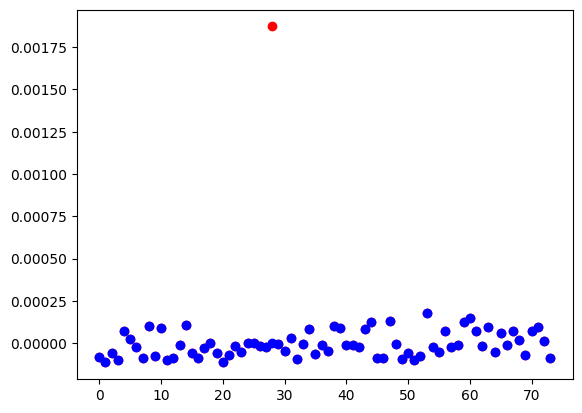

In [ ]:
# Check outlier
diffs_x_onmargin = remove_outliers_using_iqr(diffs_cov_x)
plt.scatter(range(len(diffs_cov_x)), diffs_cov_x, color = 'red')
plt.scatter(range(len(diffs_cov_x)),np.multiply(np.array(diffs_cov_x), np.array(diffs_x_onmargin).astype(int)), color = 'blue')

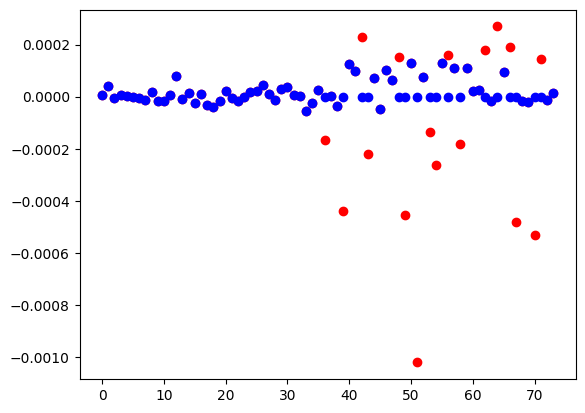

In [ ]:
a# Check outlier
diffs_y_onmargin = remove_outliers_using_iqr(diffs_cov_y)
plt.scatter(range(len(diffs_cov_y)), diffs_cov_y, color = 'red')
plt.scatter(range(len(diffs_cov_y)),np.multiply(np.array(diffs_cov_y),
                                                np.array(diffs_y_onmargin).astype(int)), color = 'blue')

In [ ]:
# OK - integrar no pipeline
new_covariances_modified = replace_covariances_outlier(new_covariances.copy(),
                                                       new_covariances_up,
                                                       new_covariances_down)

### Evaluate - Plot truth, YOLO and PX

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances[:, 0, 0]),
                                       np.sqrt(new_covariances[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g', # BOX COLOR
                                        center_color = 'g', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center - YOLO
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images_T80kenji/gaussian_{n_image}.png"
task = "detect"
model_name = "YOLOv0_T80kenji_detect"
date_train = "2023-09-04_11-19-43"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = CONFIG_RUN['image_ranges'],
                                          image_size = CONFIG_RUN['image_size'])

# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'b', # BOX COLOR
                center_color = 'red', # CENTER COLOR
                annotate_gaussians = False)


0: 640x256 80 gaussians, 193.4ms
Speed: 1.0ms preprocess, 193.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
adjust_text(all_texts)

13

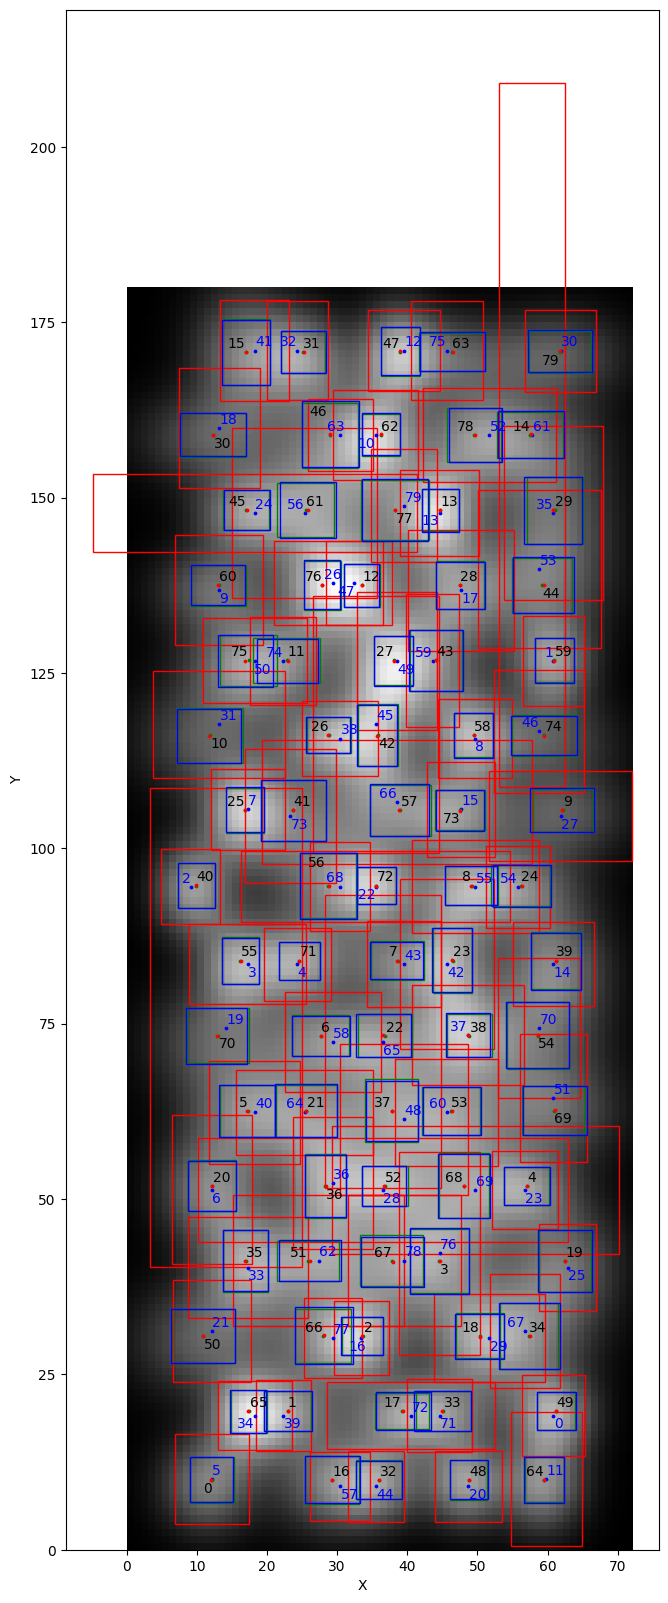

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E12_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
# Load our custom model
model_name = "YOLOv0_E12_detect"
task = "detect"
date_train = "2023-08-21_13-57-46"
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px' : [],
           'Number identifiable - YOLO_px' : [],
           'Percentage - YOLO_px' : [],
           'RMSE_cx - YOLO_px' : [],
           'RMSE_cy - YOLO_px' : [],
           'RMSE_c - YOLO_px' : [],
           'RMSE_sigmax - YOLO_px' : [],
           'RMSE_sigmay - YOLO_px' : [],
           'RMSE_sigma - YOLO_px' : [],
           'MaxE_sigmax - YOLO_px': [],
           'MaxE_sigmay - YOLO_px': [],
           'MaxE_sigma - YOLO_px': [],
           'RMSE_amplitude - YOLO_px': [],
           'RMSEPixel - YOLO_px': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 77 gaussians, 348.4ms
Speed: 1.7ms preprocess, 348.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011875           0]
  [          0   0.0076213]]]
covariances true [[[   0.011456           0]
  [          0   0.0076081]]]



0: 640x256 77 gaussians, 261.5ms
Speed: 2.1ms preprocess, 261.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013443           0]
  [          0   0.0072109]]]
covariances true [[[   0.013029           0]
  [          0   0.0069073]]]



0: 640x256 76 gaussians, 275.3ms
Speed: 4.6ms preprocess, 275.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014623           0]
  [          0   0.0059669]]]
covariances true [[[   0.014005           0]
  [          0    0.005867]]]



0: 640x256 76 gaussians, 435.7ms
Speed: 2.0ms preprocess, 435.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014398           0]
  [          0   0.0073459]]]
covariances true [[[   0.013057           0]
  [          0   0.0069026]]]



0: 640x256 78 gaussians, 426.4ms
Speed: 1.9ms preprocess, 426.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012919           0]
  [          0   0.0063217]]]
covariances true [[[   0.012098           0]
  [          0   0.0062757]]]



0: 640x256 76 gaussians, 447.8ms
Speed: 2.6ms preprocess, 447.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01608           0]
  [          0   0.0076577]]]
covariances true [[[   0.014293           0]
  [          0   0.0073547]]]



0: 640x256 77 gaussians, 423.2ms
Speed: 2.0ms preprocess, 423.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014563           0]
  [          0   0.0077548]]]
covariances true [[[   0.014285           0]
  [          0   0.0072075]]]



0: 640x256 77 gaussians, 1265.8ms
Speed: 1.9ms preprocess, 1265.8ms inference, 16.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013361           0]
  [          0   0.0070309]]]
covariances true [[[   0.012539           0]
  [          0       0.007]]]



0: 640x256 73 gaussians, 1591.2ms
Speed: 2.0ms preprocess, 1591.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015334           0]
  [          0   0.0067732]]]
covariances true [[[   0.014311           0]
  [          0   0.0066495]]]



0: 640x256 78 gaussians, 600.7ms
Speed: 1.9ms preprocess, 600.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013223           0]
  [          0   0.0077556]]]
covariances true [[[   0.012032           0]
  [          0   0.0077143]]]



0: 640x256 77 gaussians, 457.0ms
Speed: 2.0ms preprocess, 457.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014457           0]
  [          0   0.0074418]]]
covariances true [[[    0.01402           0]
  [          0   0.0072125]]]



0: 640x256 78 gaussians, 429.5ms
Speed: 2.0ms preprocess, 429.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012202           0]
  [          0   0.0062993]]]
covariances true [[[   0.011448           0]
  [          0   0.0061521]]]



0: 640x256 78 gaussians, 452.5ms
Speed: 2.1ms preprocess, 452.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01351           0]
  [          0   0.0071123]]]
covariances true [[[   0.012663           0]
  [          0   0.0070102]]]



0: 640x256 77 gaussians, 474.9ms
Speed: 1.9ms preprocess, 474.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012823           0]
  [          0   0.0077004]]]
covariances true [[[   0.012455           0]
  [          0   0.0073381]]]



0: 640x256 76 gaussians, 277.5ms
Speed: 1.9ms preprocess, 277.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015343           0]
  [          0   0.0075225]]]
covariances true [[[    0.01359           0]
  [          0   0.0073286]]]



0: 640x256 74 gaussians, 265.6ms
Speed: 2.1ms preprocess, 265.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014291           0]
  [          0   0.0068978]]]
covariances true [[[   0.013444           0]
  [          0   0.0068116]]]



0: 640x256 75 gaussians, 254.4ms
Speed: 1.9ms preprocess, 254.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011441           0]
  [          0   0.0074282]]]
covariances true [[[    0.01123           0]
  [          0   0.0070273]]]



0: 640x256 77 gaussians, 289.5ms
Speed: 2.4ms preprocess, 289.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014477           0]
  [          0   0.0069077]]]
covariances true [[[   0.013454           0]
  [          0   0.0064014]]]



0: 640x256 77 gaussians, 261.4ms
Speed: 2.3ms preprocess, 261.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014826           0]
  [          0   0.0078642]]]
covariances true [[[   0.014392           0]
  [          0   0.0073371]]]



0: 640x256 76 gaussians, 260.9ms
Speed: 2.8ms preprocess, 260.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012831           0]
  [          0   0.0064538]]]
covariances true [[[    0.01212           0]
  [          0   0.0063972]]]



0: 640x256 79 gaussians, 281.6ms
Speed: 2.0ms preprocess, 281.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.033874           0]
  [          0   0.0093457]]]
covariances true [[[   0.017368           0]
  [          0   0.0086248]]]



0: 640x256 80 gaussians, 445.7ms
Speed: 2.0ms preprocess, 445.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021513           0]
  [          0   0.0093687]]]
covariances true [[[   0.016009           0]
  [          0   0.0087787]]]



0: 640x256 80 gaussians, 444.1ms
Speed: 5.7ms preprocess, 444.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020241           0]
  [          0   0.0095557]]]
covariances true [[[   0.017855           0]
  [          0   0.0089247]]]



0: 640x256 79 gaussians, 680.0ms
Speed: 4.1ms preprocess, 680.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019688           0]
  [          0   0.0086132]]]
covariances true [[[   0.016302           0]
  [          0   0.0079472]]]



0: 640x256 80 gaussians, 769.6ms
Speed: 2.3ms preprocess, 769.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018307           0]
  [          0   0.0094155]]]
covariances true [[[   0.015694           0]
  [          0   0.0087361]]]



0: 640x256 79 gaussians, 270.6ms
Speed: 4.7ms preprocess, 270.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017637           0]
  [          0    0.010659]]]
covariances true [[[   0.015138           0]
  [          0   0.0093174]]]



0: 640x256 80 gaussians, 379.3ms
Speed: 5.8ms preprocess, 379.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019184           0]
  [          0    0.010103]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]



0: 640x256 79 gaussians, 267.7ms
Speed: 2.5ms preprocess, 267.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023071           0]
  [          0   0.0093984]]]
covariances true [[[    0.01625           0]
  [          0   0.0088413]]]



0: 640x256 79 gaussians, 260.1ms
Speed: 3.8ms preprocess, 260.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028044           0]
  [          0    0.010158]]]
covariances true [[[   0.016485           0]
  [          0   0.0082784]]]



0: 640x256 80 gaussians, 274.5ms
Speed: 1.5ms preprocess, 274.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.024279           0]
  [          0   0.0088671]]]
covariances true [[[   0.016971           0]
  [          0   0.0081787]]]



0: 640x256 79 gaussians, 251.5ms
Speed: 2.6ms preprocess, 251.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023175           0]
  [          0    0.010101]]]
covariances true [[[   0.016689           0]
  [          0   0.0090616]]]



0: 640x256 79 gaussians, 268.1ms
Speed: 1.8ms preprocess, 268.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017016           0]
  [          0   0.0093758]]]
covariances true [[[    0.01503           0]
  [          0   0.0088039]]]



0: 640x256 79 gaussians, 272.9ms
Speed: 2.0ms preprocess, 272.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019738           0]
  [          0    0.009626]]]
covariances true [[[   0.015653           0]
  [          0   0.0085055]]]



0: 640x256 79 gaussians, 257.7ms
Speed: 2.8ms preprocess, 257.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018808           0]
  [          0   0.0092681]]]
covariances true [[[   0.015368           0]
  [          0   0.0079957]]]



0: 640x256 79 gaussians, 268.2ms
Speed: 2.6ms preprocess, 268.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020947           0]
  [          0   0.0090802]]]
covariances true [[[   0.015066           0]
  [          0     0.00857]]]



0: 640x256 79 gaussians, 267.6ms
Speed: 2.0ms preprocess, 267.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020857           0]
  [          0    0.010753]]]
covariances true [[[   0.015879           0]
  [          0   0.0087753]]]



0: 640x256 80 gaussians, 278.9ms
Speed: 2.8ms preprocess, 278.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018067           0]
  [          0    0.010081]]]
covariances true [[[   0.015896           0]
  [          0   0.0088842]]]



0: 640x256 79 gaussians, 257.5ms
Speed: 1.6ms preprocess, 257.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018318           0]
  [          0     0.01004]]]
covariances true [[[   0.015484           0]
  [          0   0.0086454]]]



0: 640x256 81 gaussians, 369.9ms
Speed: 1.9ms preprocess, 369.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018774           0]
  [          0   0.0093099]]]
covariances true [[[    0.01689           0]
  [          0   0.0086072]]]



0: 640x256 79 gaussians, 530.2ms
Speed: 1.9ms preprocess, 530.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021737           0]
  [          0   0.0097289]]]
covariances true [[[   0.017898           0]
  [          0    0.009004]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std         max
Image                              218.95     124.81      399.00
Number identified - YOLO_px         77.95       1.78       81.00
Number identifiable - YOLO_px       79.05       0.55       80.00
Percentage - YOLO_px                98.61       2.23      102.53
RMSE_cx - YOLO_px                    1.55       1.00        3.18
RMSE_cy - YOLO_px                    0.37       0.06        0.60
RMSE_c - YOLO_px                     1.62       0.95        3.24
RMSE_sigmax - YOLO_px               23.91      18.36       74.28
RMSE_sigmay - YOLO_px               24.54       9.31       58.41
RMSE_sigma - YOLO_px                37.77      12.82       76.99
MaxE_sigmax - YOLO_px              390.08     659.11     3681.44
MaxE_sigmay - YOLO_px              331.55     341.21     1829.82
MaxE_sigma - YOLO_px               629.04     643.29     3683.92
RMSE_amplitude - YOLO_px            19.44       7.22       30.61
RMSEPixel - YOLO_px            1149160.20  201985.69  1632773.30

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E12YOLOPX")

## Evaluate - Plot Truth, YOLO and PX infer

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in converted_new_means_infer],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(new_covariances_infer[:, 0, 0]),
                                       np.sqrt(new_covariances_infer[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b', # CENTER COLOR
                                  annotate_gaussians = True,
                                  text_color = 'blue')

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g', # BOX COLOR
                                        center_color = 'g', # CENTER COLOR
                                        annotate_gaussians = True)

In [ ]:
# Plot box and center -  YOLO
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in
                  zip(np.sqrt(covariances[:, 0, 0]),
                      np.sqrt(covariances[:, 1, 1]))],
                ax = ax,
                box_edge_color = 'b', # BOX COLOR
                center_color = 'red', # CENTER COLOR
                annotate_gaussians = False)

In [ ]:
adjust_text(all_texts)

10

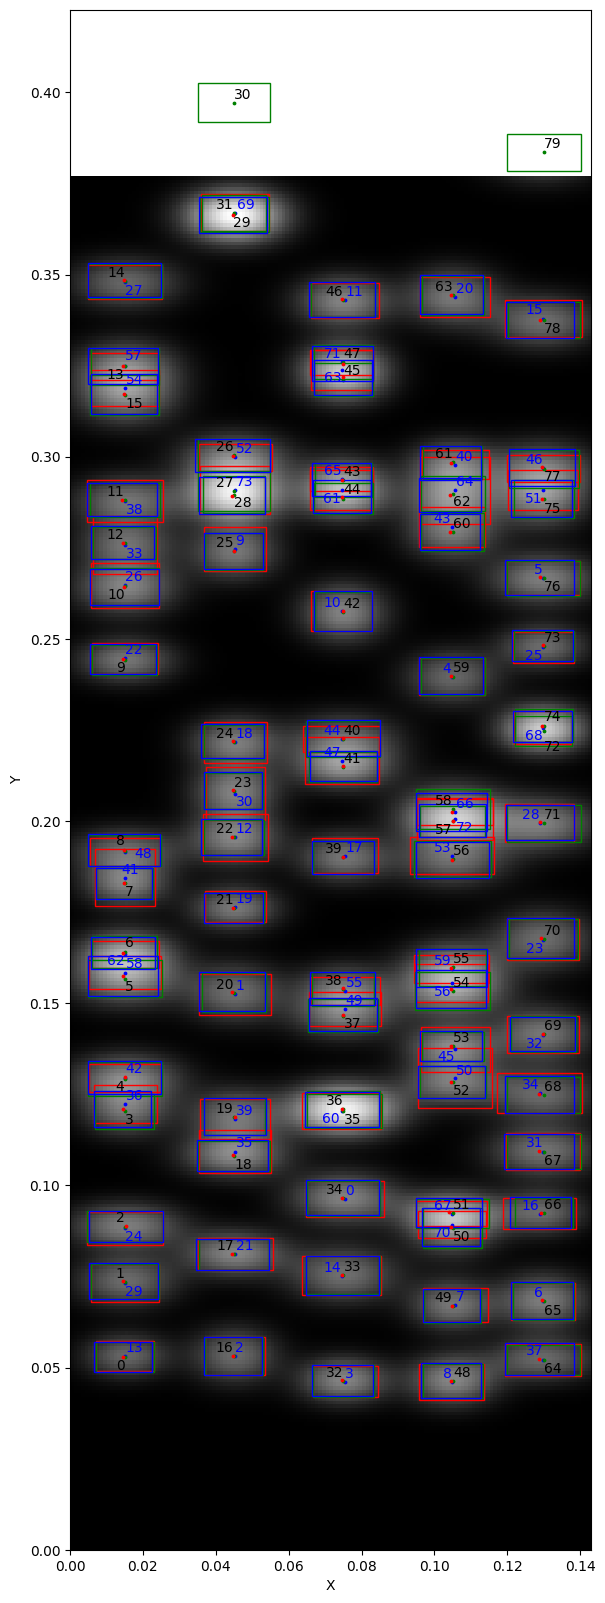

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX Infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E12_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[156, 74, 6, 60, 166, 128, 88, 65, 177, 176, 37, 116, 39, 188, 110, 98, 62, 93, 178, 149, 364, 386, 345, 367, 398, 385, 348, 399, 308, 290, 205, 340, 295, 269, 395, 246, 292, 352, 354, 254]


In [ ]:
# Load our custom model
model_name = "YOLOv0_E12_detect"
task = "detect"
date_train = "2023-08-21_13-57-46"
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/{date_train}/{task}/train/weights/best.pt")

# Image root path
image_path = "/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO_px_infer' : [],
           'Number identifiable - YOLO_px_infer' : [],
           'Percentage - YOLO_px_infer' : [],
           'RMSE_cx - YOLO_px_infer' : [],
           'RMSE_cy - YOLO_px_infer' : [],
           'RMSE_c - YOLO_px_infer' : [],
           'RMSE_sigmax - YOLO_px_infer' : [],
           'RMSE_sigmay - YOLO_px_infer' : [],
           'RMSE_sigma - YOLO_px_infer' : [],
           'MaxE_sigmax - YOLO_px_infer': [],
           'MaxE_sigmay - YOLO_px_infer': [],
           'MaxE_sigma - YOLO_px_infer': [],
           'RMSE_amplitude - YOLO_px_infer': [],
           'RMSEPixel - YOLO_px_infer': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO_px_infer",
                                       image_path = image_path,
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 77 gaussians, 326.1ms
Speed: 3.5ms preprocess, 326.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011875           0]
  [          0   0.0076213]]]
covariances true [[[   0.011456           0]
  [          0   0.0076081]]]



0: 640x256 77 gaussians, 252.4ms
Speed: 2.0ms preprocess, 252.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013443           0]
  [          0   0.0072109]]]
covariances true [[[   0.013029           0]
  [          0   0.0069073]]]



0: 640x256 76 gaussians, 257.2ms
Speed: 4.8ms preprocess, 257.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014623           0]
  [          0   0.0059669]]]
covariances true [[[   0.014005           0]
  [          0    0.005867]]]



0: 640x256 76 gaussians, 250.1ms
Speed: 5.1ms preprocess, 250.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014398           0]
  [          0   0.0073459]]]
covariances true [[[   0.013057           0]
  [          0   0.0069026]]]



0: 640x256 78 gaussians, 265.6ms
Speed: 1.9ms preprocess, 265.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012919           0]
  [          0   0.0063217]]]
covariances true [[[   0.012098           0]
  [          0   0.0062757]]]



0: 640x256 76 gaussians, 263.7ms
Speed: 2.1ms preprocess, 263.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01608           0]
  [          0   0.0076577]]]
covariances true [[[   0.014293           0]
  [          0   0.0073547]]]



0: 640x256 77 gaussians, 255.4ms
Speed: 2.6ms preprocess, 255.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014563           0]
  [          0   0.0077548]]]
covariances true [[[   0.014285           0]
  [          0   0.0072075]]]



0: 640x256 77 gaussians, 572.2ms
Speed: 3.7ms preprocess, 572.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013361           0]
  [          0   0.0070309]]]
covariances true [[[   0.012539           0]
  [          0       0.007]]]



0: 640x256 73 gaussians, 477.5ms
Speed: 2.3ms preprocess, 477.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015334           0]
  [          0   0.0067732]]]
covariances true [[[   0.014311           0]
  [          0   0.0066495]]]



0: 640x256 78 gaussians, 378.2ms
Speed: 2.1ms preprocess, 378.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013223           0]
  [          0   0.0077556]]]
covariances true [[[   0.012032           0]
  [          0   0.0077143]]]



0: 640x256 77 gaussians, 761.2ms
Speed: 4.8ms preprocess, 761.2ms inference, 8.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014457           0]
  [          0   0.0074418]]]
covariances true [[[    0.01402           0]
  [          0   0.0072125]]]



0: 640x256 78 gaussians, 873.5ms
Speed: 2.0ms preprocess, 873.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012202           0]
  [          0   0.0062993]]]
covariances true [[[   0.011448           0]
  [          0   0.0061521]]]



0: 640x256 78 gaussians, 765.9ms
Speed: 1.9ms preprocess, 765.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01351           0]
  [          0   0.0071123]]]
covariances true [[[   0.012663           0]
  [          0   0.0070102]]]



0: 640x256 77 gaussians, 502.0ms
Speed: 1.9ms preprocess, 502.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012823           0]
  [          0   0.0077004]]]
covariances true [[[   0.012455           0]
  [          0   0.0073381]]]



0: 640x256 76 gaussians, 460.7ms
Speed: 2.0ms preprocess, 460.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015343           0]
  [          0   0.0075225]]]
covariances true [[[    0.01359           0]
  [          0   0.0073286]]]



0: 640x256 74 gaussians, 264.8ms
Speed: 2.6ms preprocess, 264.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014291           0]
  [          0   0.0068978]]]
covariances true [[[   0.013444           0]
  [          0   0.0068116]]]



0: 640x256 75 gaussians, 280.7ms
Speed: 4.3ms preprocess, 280.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011441           0]
  [          0   0.0074282]]]
covariances true [[[    0.01123           0]
  [          0   0.0070273]]]



0: 640x256 77 gaussians, 251.1ms
Speed: 1.9ms preprocess, 251.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014477           0]
  [          0   0.0069077]]]
covariances true [[[   0.013454           0]
  [          0   0.0064014]]]



0: 640x256 77 gaussians, 261.8ms
Speed: 4.0ms preprocess, 261.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014826           0]
  [          0   0.0078642]]]
covariances true [[[   0.014392           0]
  [          0   0.0073371]]]



0: 640x256 76 gaussians, 411.2ms
Speed: 2.2ms preprocess, 411.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012831           0]
  [          0   0.0064538]]]
covariances true [[[    0.01212           0]
  [          0   0.0063972]]]



0: 640x256 79 gaussians, 302.5ms
Speed: 1.9ms preprocess, 302.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.033874           0]
  [          0   0.0093457]]]
covariances true [[[   0.017368           0]
  [          0   0.0086248]]]



0: 640x256 80 gaussians, 463.0ms
Speed: 4.6ms preprocess, 463.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.021513           0]
  [          0   0.0093687]]]
covariances true [[[   0.016009           0]
  [          0   0.0087787]]]



0: 640x256 80 gaussians, 434.4ms
Speed: 1.9ms preprocess, 434.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.020241           0]
  [          0   0.0095557]]]
covariances true [[[   0.017855           0]
  [          0   0.0089247]]]



0: 640x256 79 gaussians, 326.1ms
Speed: 1.9ms preprocess, 326.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019688           0]
  [          0   0.0086132]]]
covariances true [[[   0.016302           0]
  [          0   0.0079472]]]



0: 640x256 80 gaussians, 1053.7ms
Speed: 1.9ms preprocess, 1053.7ms inference, 14.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018307           0]
  [          0   0.0094155]]]
covariances true [[[   0.015694           0]
  [          0   0.0087361]]]



0: 640x256 79 gaussians, 1627.4ms
Speed: 1.9ms preprocess, 1627.4ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017637           0]
  [          0    0.010659]]]
covariances true [[[   0.015138           0]
  [          0   0.0093174]]]



0: 640x256 80 gaussians, 533.0ms
Speed: 2.0ms preprocess, 533.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019184           0]
  [          0    0.010103]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]



0: 640x256 79 gaussians, 430.4ms
Speed: 3.8ms preprocess, 430.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023071           0]
  [          0   0.0093984]]]
covariances true [[[    0.01625           0]
  [          0   0.0088413]]]



0: 640x256 79 gaussians, 418.1ms
Speed: 2.5ms preprocess, 418.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.028044           0]
  [          0    0.010158]]]
covariances true [[[   0.016485           0]
  [          0   0.0082784]]]



0: 640x256 80 gaussians, 407.1ms
Speed: 2.2ms preprocess, 407.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.024279           0]
  [          0   0.0088671]]]
covariances true [[[   0.016971           0]
  [          0   0.0081787]]]



0: 640x256 79 gaussians, 269.6ms
Speed: 2.0ms preprocess, 269.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023175           0]
  [          0    0.010101]]]
covariances true [[[   0.016689           0]
  [          0   0.0090616]]]



0: 640x256 79 gaussians, 260.6ms
Speed: 1.9ms preprocess, 260.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017016           0]
  [          0   0.0093758]]]
covariances true [[[    0.01503           0]
  [          0   0.0088039]]]



0: 640x256 79 gaussians, 265.1ms
Speed: 2.2ms preprocess, 265.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019738           0]
  [          0    0.009626]]]
covariances true [[[   0.015653           0]
  [          0   0.0085055]]]



0: 640x256 79 gaussians, 250.5ms
Speed: 2.3ms preprocess, 250.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018808           0]
  [          0   0.0092681]]]
covariances true [[[   0.015368           0]
  [          0   0.0079957]]]



0: 640x256 79 gaussians, 252.8ms
Speed: 2.2ms preprocess, 252.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020947           0]
  [          0   0.0090802]]]
covariances true [[[   0.015066           0]
  [          0     0.00857]]]



0: 640x256 79 gaussians, 263.3ms
Speed: 1.8ms preprocess, 263.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020857           0]
  [          0    0.010753]]]
covariances true [[[   0.015879           0]
  [          0   0.0087753]]]



0: 640x256 80 gaussians, 252.7ms
Speed: 4.5ms preprocess, 252.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018067           0]
  [          0    0.010081]]]
covariances true [[[   0.015896           0]
  [          0   0.0088842]]]



0: 640x256 79 gaussians, 1601.5ms
Speed: 1.9ms preprocess, 1601.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018318           0]
  [          0     0.01004]]]
covariances true [[[   0.015484           0]
  [          0   0.0086454]]]



0: 640x256 81 gaussians, 446.7ms
Speed: 1.9ms preprocess, 446.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-11-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.018774           0]
  [          0   0.0093099]]]
covariances true [[[    0.01689           0]
  [          0   0.0086072]]]



0: 640x256 79 gaussians, 447.6ms
Speed: 1.8ms preprocess, 447.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.021737           0]
  [          0   0.0097289]]]
covariances true [[[   0.017898           0]
  [          0    0.009004]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std         max
Image                                   218.95     124.81      399.00
Number identified - YOLO_px_infer        77.95       1.78       81.00
Number identifiable - YOLO_px_infer      79.05       0.55       80.00
Percentage - YOLO_px_infer               98.61       2.23      102.53
RMSE_cx - YOLO_px_infer                   1.55       1.00        3.18
RMSE_cy - YOLO_px_infer                   0.37       0.06        0.60
RMSE_c - YOLO_px_infer                    1.62       0.95        3.24
RMSE_sigmax - YOLO_px_infer              15.18       8.70       26.44
RMSE_sigmay - YOLO_px_infer              14.63       2.56       24.89
RMSE_sigma - YOLO_px_infer               21.99       6.49       30.59
MaxE_sigmax - YOLO_px_infer              52.65      29.10      115.08
MaxE_sigmay - YOLO_px_infer              93.45      96.02      617.08
MaxE_sigma - YOLO_px_infer              116.04      89.77      617.32
RMSE_amplitude - YOLO_px_infer           19.44       7.22       30.61
RMSEPixel - YOLO_px_infer            845521.55  126669.76  1165782.87

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E12YOLOPXINFER")

## [ESTIMATION] Pipeline ensembled (PX and YOLO)

In [ ]:
# Load data
n_image = 109

# Image - z intensities
image = [x,
         y,
         mat['F_data'][:,:, n_image]]

image_ranges = [(0, 0.143),
                (0, 0.377)]
image_size = [143, 377]

# Parameters extraction
(amplitude,
 xs,
 ys,
 dispersion_x,
 dispersion_y) = parameters_extract(mat['Fit_flux'], n_image)

#### ERROR MSEP evaluation - YOLO + Refinning -
- Compare values by reconstruction with the estimated parameters (per Gaussian)

##### Each Gaussian error estimation

In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [np.array([[(wx/(np.sqrt(2)))**2, 0],
                               [0, (wy/(np.sqrt(2)))**2]]) for
                     wx, wy in zip(dispersion_x, dispersion_y)]
amplitudes_truth = amplitude
(all_gaussians_truth,
 generated_z_truth,
 rmsep_truth,
 error_gaussians_truth) = compute_error_per_gaussian(image,
                                                     means_truth,
                                                     covariances_truth,
                                                     amplitudes_truth)

Gaussian 30 center is out of bounds
Gaussian 79 center is out of bounds


In [ ]:
# Compute YOLO
(all_gaussians_yolo,
 generated_z_yolo,
 rmsep_yolo,
 error_gaussians_yolo) = compute_error_per_gaussian(image,
                                                    means,
                                                    list(covariances/2),
                                                    amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(all_gaussians_px,
 generated_z_px,
 rmsep_px,
 error_gaussians_px) = compute_error_per_gaussian(image,
                                                  converted_new_means,
                                                  list(new_covariances/2),
                                                  amplitudes_px)

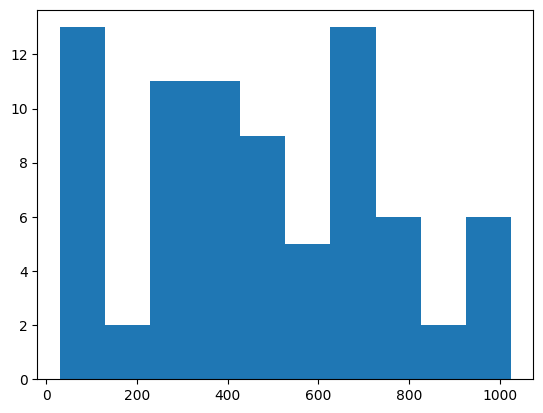

In [ ]:
# Error Yolo
plt.hist(error_gaussians_truth)
plt.show()

Max error gaussian = 72
Min error gaussian = 14


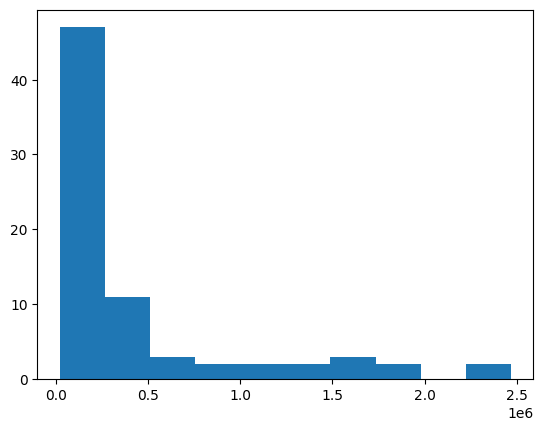

In [ ]:
# Error Yolo
plt.hist(error_gaussians_yolo)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_yolo))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_yolo))}')

Max error gaussian = 70
Min error gaussian = 27


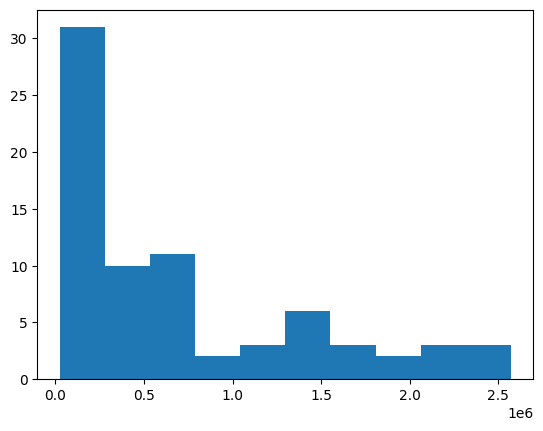

In [ ]:
# Error PX
plt.hist(error_gaussians_px)

# Gaussian min / max error
print(f'Max error gaussian = {np.argmax(np.array(error_gaussians_px))}')
print(f'Min error gaussian = {np.argmin(np.array(error_gaussians_px))}')

In [ ]:
# Important: when covariance/center changes, the region being evaluated will change, this should happend?
# I think so, as the Gaussian estimated need to be compared to the exact location in the image that it was estimated
# Is it possible in any circunstance the error be lower because of the treatd region?

#### [Study] Creating the means and covariances of the mixed models

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(n_image,
                                      mat_data = mat,
                                      estimation_method = ["YOLO", "YOLO_px"],
                                      peak_method = None,
                                      image_path = image_path,
                                      yolo_model = model,
                                      print_bettersecond = True)


0: 640x256 74 gaussians, 303.2ms
Speed: 2.2ms preprocess, 303.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 235.4ms
Speed: 1.9ms preprocess, 235.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 256)


[4, 5, 13, 27, 37, 68]


In [ ]:
# Generates gaussian
generated_z_ensembled_2 = sum_gaussians(image[0], # x
                                      image[1], # y
                                      all_gaussians_ensembled)

In [ ]:
# Error of the ensemble
(all_gaussians_ensembled,
generated_z_ensembled,
rmsep_ensembled,
error_gaussians_ensembled) = compute_error_per_gaussian(image,
                                  [i[0] for i in all_gaussians_ensembled],
                                  list(np.array([i[1] for i in
                                                all_gaussians_ensembled])/2),
                                  [i[2] for i in all_gaussians_ensembled])

In [ ]:
# Comparing errors - Problem is the error is lower in the context in the method
pd.DataFrame([error_gaussians_yolo, error_gaussians_px, error_gaussians_ensembled_2]).T

0             1             2
0   4.544691e+04  1.613277e+05  4.544691e+04
1   5.280561e+04  1.684567e+05  5.654977e+04
2   2.537606e+04  3.439260e+04  2.645817e+04
3   4.031923e+04  9.394205e+04  4.031752e+04
4   4.501023e+04  2.715165e+04  2.655403e+04
..           ...           ...           ...
69  1.071002e+05  1.215624e+05  1.070769e+05
70  1.545039e+06  2.570100e+06  1.545039e+06
71  1.752819e+06  2.362264e+06  2.325127e+06
72  2.468326e+06  1.868154e+06  2.579802e+06
73  2.295203e+05  4.238663e+05  2.295202e+05

[74 rows x 3 columns]

### Error evaluation ensemble Yolo and PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E12_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[156, 74, 6, 60, 166, 128, 88, 65, 177, 176, 37, 116, 39, 188, 110, 98, 62, 93, 178, 149, 364, 386, 345, 367, 398, 385, 348, 399, 308, 290, 205, 340, 295, 269, 395, 246, 292, 352, 354, 254]


In [ ]:
# Image path for error_estimation should be the folder of images
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = image_path,
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 77 gaussians, 528.3ms
Speed: 2.1ms preprocess, 528.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 447.5ms
Speed: 1.9ms preprocess, 447.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01152           0]
  [          0   0.0076559]]]
covariances true [[[   0.011456           0]
  [          0   0.0076081]]]



0: 640x256 77 gaussians, 446.5ms
Speed: 2.0ms preprocess, 446.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 446.0ms
Speed: 2.0ms preprocess, 446.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013246           0]
  [          0   0.0068977]]]
covariances true [[[   0.013029           0]
  [          0   0.0069073]]]



0: 640x256 76 gaussians, 1060.2ms
Speed: 2.4ms preprocess, 1060.2ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 418.0ms
Speed: 1.9ms preprocess, 418.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014082           0]
  [          0    0.005895]]]
covariances true [[[   0.014005           0]
  [          0    0.005867]]]



0: 640x256 76 gaussians, 865.3ms
Speed: 2.0ms preprocess, 865.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 1462.8ms
Speed: 2.5ms preprocess, 1462.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013251           0]
  [          0   0.0067876]]]
covariances true [[[   0.013057           0]
  [          0   0.0069026]]]



0: 640x256 78 gaussians, 745.2ms
Speed: 3.3ms preprocess, 745.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 551.9ms
Speed: 2.6ms preprocess, 551.9ms inference, 10.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012262           0]
  [          0   0.0063411]]]
covariances true [[[   0.012098           0]
  [          0   0.0062757]]]



0: 640x256 76 gaussians, 694.8ms
Speed: 2.0ms preprocess, 694.8ms inference, 11.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 1259.9ms
Speed: 4.5ms preprocess, 1259.9ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014357           0]
  [          0   0.0073565]]]
covariances true [[[   0.014293           0]
  [          0   0.0073547]]]



0: 640x256 77 gaussians, 589.0ms
Speed: 2.3ms preprocess, 589.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 1103.8ms
Speed: 2.1ms preprocess, 1103.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014419           0]
  [          0   0.0072034]]]
covariances true [[[   0.014285           0]
  [          0   0.0072075]]]



0: 640x256 77 gaussians, 625.3ms
Speed: 2.0ms preprocess, 625.3ms inference, 4.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 454.8ms
Speed: 2.0ms preprocess, 454.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012577           0]
  [          0   0.0071186]]]
covariances true [[[   0.012539           0]
  [          0       0.007]]]



0: 640x256 73 gaussians, 417.6ms
Speed: 1.9ms preprocess, 417.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 73 gaussians, 455.3ms
Speed: 4.8ms preprocess, 455.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014498           0]
  [          0   0.0066782]]]
covariances true [[[   0.014311           0]
  [          0   0.0066495]]]



0: 640x256 78 gaussians, 459.1ms
Speed: 2.0ms preprocess, 459.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 253.5ms
Speed: 2.5ms preprocess, 253.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01208           0]
  [          0   0.0077728]]]
covariances true [[[   0.012032           0]
  [          0   0.0077143]]]



0: 640x256 77 gaussians, 279.4ms
Speed: 2.5ms preprocess, 279.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 273.1ms
Speed: 2.1ms preprocess, 273.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014071           0]
  [          0   0.0072587]]]
covariances true [[[    0.01402           0]
  [          0   0.0072125]]]



0: 640x256 78 gaussians, 268.0ms
Speed: 1.8ms preprocess, 268.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 270.0ms
Speed: 2.9ms preprocess, 270.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011617           0]
  [          0   0.0062129]]]
covariances true [[[   0.011448           0]
  [          0   0.0061521]]]



0: 640x256 78 gaussians, 446.8ms
Speed: 1.9ms preprocess, 446.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 446.2ms
Speed: 1.9ms preprocess, 446.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012757           0]
  [          0   0.0070232]]]
covariances true [[[   0.012663           0]
  [          0   0.0070102]]]



0: 640x256 77 gaussians, 453.6ms
Speed: 2.0ms preprocess, 453.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 449.0ms
Speed: 4.4ms preprocess, 449.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012485           0]
  [          0   0.0072914]]]
covariances true [[[   0.012455           0]
  [          0   0.0073381]]]



0: 640x256 76 gaussians, 253.8ms
Speed: 2.2ms preprocess, 253.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 266.8ms
Speed: 1.5ms preprocess, 266.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013652           0]
  [          0   0.0073498]]]
covariances true [[[    0.01359           0]
  [          0   0.0073286]]]



0: 640x256 74 gaussians, 267.5ms
Speed: 2.1ms preprocess, 267.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 256.6ms
Speed: 2.2ms preprocess, 256.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013539           0]
  [          0   0.0068485]]]
covariances true [[[   0.013444           0]
  [          0   0.0068116]]]



0: 640x256 75 gaussians, 257.9ms
Speed: 1.5ms preprocess, 257.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 264.8ms
Speed: 2.2ms preprocess, 264.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011324           0]
  [          0   0.0071303]]]
covariances true [[[    0.01123           0]
  [          0   0.0070273]]]



0: 640x256 77 gaussians, 268.4ms
Speed: 2.8ms preprocess, 268.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 258.4ms
Speed: 5.2ms preprocess, 258.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013536           0]
  [          0   0.0064495]]]
covariances true [[[   0.013454           0]
  [          0   0.0064014]]]



0: 640x256 77 gaussians, 264.6ms
Speed: 2.0ms preprocess, 264.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 265.0ms
Speed: 2.0ms preprocess, 265.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013752           0]
  [          0   0.0075211]]]
covariances true [[[   0.014392           0]
  [          0   0.0073371]]]



0: 640x256 76 gaussians, 268.0ms
Speed: 2.9ms preprocess, 268.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 312.1ms
Speed: 1.9ms preprocess, 312.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012209           0]
  [          0   0.0064438]]]
covariances true [[[    0.01212           0]
  [          0   0.0063972]]]



0: 640x256 79 gaussians, 1089.3ms
Speed: 1.9ms preprocess, 1089.3ms inference, 9.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 460.5ms
Speed: 1.9ms preprocess, 460.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017047           0]
  [          0     0.00863]]]
covariances true [[[   0.017368           0]
  [          0   0.0086248]]]



0: 640x256 80 gaussians, 258.1ms
Speed: 1.8ms preprocess, 258.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 282.2ms
Speed: 2.0ms preprocess, 282.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015922           0]
  [          0   0.0088045]]]
covariances true [[[   0.016009           0]
  [          0   0.0087787]]]



0: 640x256 80 gaussians, 276.8ms
Speed: 1.9ms preprocess, 276.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 256.1ms
Speed: 2.0ms preprocess, 256.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017749           0]
  [          0   0.0088854]]]
covariances true [[[   0.017855           0]
  [          0   0.0089247]]]



0: 640x256 79 gaussians, 260.5ms
Speed: 3.0ms preprocess, 260.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 272.9ms
Speed: 2.2ms preprocess, 272.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016311           0]
  [          0   0.0079236]]]
covariances true [[[   0.016302           0]
  [          0   0.0079472]]]



0: 640x256 80 gaussians, 267.1ms
Speed: 2.3ms preprocess, 267.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 267.0ms
Speed: 2.5ms preprocess, 267.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015779           0]
  [          0   0.0087974]]]
covariances true [[[   0.015694           0]
  [          0   0.0087361]]]



0: 640x256 79 gaussians, 272.9ms
Speed: 1.8ms preprocess, 272.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 253.6ms
Speed: 2.2ms preprocess, 253.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015254           0]
  [          0   0.0093527]]]
covariances true [[[   0.015138           0]
  [          0   0.0093174]]]



0: 640x256 80 gaussians, 262.5ms
Speed: 2.6ms preprocess, 262.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 255.2ms
Speed: 2.0ms preprocess, 255.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016462           0]
  [          0   0.0091977]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]



0: 640x256 79 gaussians, 445.7ms
Speed: 2.3ms preprocess, 445.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 438.6ms
Speed: 1.9ms preprocess, 438.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016274           0]
  [          0   0.0088483]]]
covariances true [[[    0.01625           0]
  [          0   0.0088413]]]



0: 640x256 79 gaussians, 446.4ms
Speed: 1.9ms preprocess, 446.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 768.5ms
Speed: 1.9ms preprocess, 768.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016577           0]
  [          0   0.0082585]]]
covariances true [[[   0.016485           0]
  [          0   0.0082784]]]



0: 640x256 80 gaussians, 268.1ms
Speed: 2.0ms preprocess, 268.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 270.4ms
Speed: 2.9ms preprocess, 270.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016877           0]
  [          0     0.00824]]]
covariances true [[[   0.016971           0]
  [          0   0.0081787]]]



0: 640x256 79 gaussians, 272.7ms
Speed: 5.2ms preprocess, 272.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 259.6ms
Speed: 4.4ms preprocess, 259.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01471           0]
  [          0    0.009004]]]
covariances true [[[   0.016689           0]
  [          0   0.0090616]]]



0: 640x256 79 gaussians, 261.9ms
Speed: 2.0ms preprocess, 261.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 262.7ms
Speed: 1.8ms preprocess, 262.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015123           0]
  [          0   0.0088901]]]
covariances true [[[    0.01503           0]
  [          0   0.0088039]]]



0: 640x256 79 gaussians, 263.6ms
Speed: 1.6ms preprocess, 263.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 276.2ms
Speed: 2.6ms preprocess, 276.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015693           0]
  [          0   0.0085176]]]
covariances true [[[   0.015653           0]
  [          0   0.0085055]]]



0: 640x256 79 gaussians, 287.9ms
Speed: 5.7ms preprocess, 287.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 342.1ms
Speed: 3.3ms preprocess, 342.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015486           0]
  [          0   0.0081205]]]
covariances true [[[   0.015368           0]
  [          0   0.0079957]]]



0: 640x256 79 gaussians, 813.0ms
Speed: 2.0ms preprocess, 813.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 1325.0ms
Speed: 1.9ms preprocess, 1325.0ms inference, 18.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015414           0]
  [          0   0.0086324]]]
covariances true [[[   0.015066           0]
  [          0     0.00857]]]



0: 640x256 79 gaussians, 300.2ms
Speed: 2.4ms preprocess, 300.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 295.0ms
Speed: 2.8ms preprocess, 295.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016028           0]
  [          0   0.0088321]]]
covariances true [[[   0.015879           0]
  [          0   0.0087753]]]



0: 640x256 80 gaussians, 467.4ms
Speed: 2.0ms preprocess, 467.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 467.9ms
Speed: 2.2ms preprocess, 467.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015783           0]
  [          0   0.0088333]]]
covariances true [[[   0.015896           0]
  [          0   0.0088842]]]



0: 640x256 79 gaussians, 444.8ms
Speed: 2.1ms preprocess, 444.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 464.5ms
Speed: 1.9ms preprocess, 464.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015536           0]
  [          0   0.0087228]]]
covariances true [[[   0.015484           0]
  [          0   0.0086454]]]



0: 640x256 81 gaussians, 795.5ms
Speed: 1.9ms preprocess, 795.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 447.0ms
Speed: 2.0ms preprocess, 447.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017151           0]
  [          0   0.0086221]]]
covariances true [[[    0.01689           0]
  [          0   0.0086072]]]



0: 640x256 79 gaussians, 452.6ms
Speed: 1.9ms preprocess, 452.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 439.2ms
Speed: 2.1ms preprocess, 439.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017853           0]
  [          0   0.0089644]]]
covariances true [[[   0.017898           0]
  [          0    0.009004]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std        max
Image                               218.95     124.81     399.00
Number identified - ensembled        77.95       1.78      81.00
Number identifiable - ensembled      79.05       0.55      80.00
Percentage - ensembled               98.61       2.23     102.53
RMSE_cx - ensembled                   1.67       0.72       3.58
RMSE_cy - ensembled                   0.09       0.04       0.32
RMSE_c - ensembled                    1.68       0.72       3.60
RMSE_sigmax - ensembled               4.25       2.66       8.67
RMSE_sigmay - ensembled               1.91       0.64       3.30
RMSE_sigma - ensembled                4.86       2.35       9.10
MaxE_sigmax - ensembled              31.43      22.72      87.94
MaxE_sigmay - ensembled              33.05      27.03      85.40
MaxE_sigma - ensembled               49.43      29.57     122.58
RMSE_amplitude - ensembled           17.32       6.24      27.36
RMSEPixel - ensembled            419660.69  134487.96  722277.90

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - ensembled  Number identifiable - ensembled  \
2       6                             76                               79   
10     37                             77                               78   
12     39                             78                               80   
3      60                             76                               79   
16     62                             75                               78   
7      65                             77                               80   
1      74                             77                               80   
6      88                             77                               79   
17     93                             77                               78   
15     98                             74                               79   
14    110                             76                               79   
11    116                             78                               80   
5     128                             76                               80   
19    149                             76                               78   
0     156                             77                               80   
4     166                             78                               80   
9     176                             78                               79   
8     177                             73                               78   
18    178                             77                               79   
13    188                             77                               79   
30    205                             79                               79   
35    246                             79                               79   
39    254                             79                               79   
33    269                             79                               79   
29    290                             80                               79   
36    292                             80                               79   
32    295                             79                               79   
28    308                             79                               79   
31    340                             79                               79   
22    345                             80                               79   
26    348                             80                               79   
37    352                             79                               79   
38    354                             81                               79   
20    364                             79                               79   
23    367                             79                               79   
25    385                             79                               79   
21    386                             80                               79   
34    395                             79                               79   
24    398                             80                               79   
27    399                             79                               79   

    Percentage - ensembled  RMSE_cx - ensembled  RMSE_cy - ensembled  \
2                    96.20                 0.99                 0.06   
10                   98.72                 0.89                 0.08   
12                   97.50                 0.90                 0.08   
3                    96.20                 1.02                 0.10   
16                   96.15                 1.09                 0.08   
7                    96.25                 1.12                 0.08   
1                    96.25                 0.98                 0.10   
6                    97.47                 0.86                 0.10   
17                   98.72                 1.09                 0.07   
15                   93.67                 0.91                 0.11   
14                   96.20                 3.58       

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E12YOLOENSEBPX")

### Error evaluation ensemble Yolo and PX - infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir("/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/YOLOv0_E12_detect/datasets/test/images/")
eval_images = [int(i.split('_')[1].split('.')[0]) for i in images_test] # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[156, 74, 6, 60, 166, 128, 88, 65, 177, 176, 37, 116, 39, 188, 110, 98, 62, 93, 178, 149, 364, 386, 345, 367, 398, 385, 348, 399, 308, 290, 205, 340, 295, 269, 395, 246, 292, 352, 354, 254]


In [ ]:
# Image path for error_estimation should be the folder of images
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/"

In [ ]:
# Iterate all images - ensembled method
results = {'Image' : [],
           'Number identified - ensembled' : [],
           'Number identifiable - ensembled' : [],
           'Percentage - ensembled' : [],
           'RMSE_cx - ensembled' : [],
           'RMSE_cy - ensembled' : [],
           'RMSE_c - ensembled' : [],
           'RMSE_sigmax - ensembled' : [],
           'RMSE_sigmay - ensembled' : [],
           'RMSE_sigma - ensembled' : [],
           'MaxE_sigmax - ensembled': [],
           'MaxE_sigmay - ensembled': [],
           'MaxE_sigma - ensembled': [],
           'RMSE_amplitude - ensembled': [],
           'RMSEPixel - ensembled': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       image_path = image_path,
                                       peak_method = 'laplace',
                                       yolo_model = model,
                                       estimation_method = ["YOLO", "YOLO_px_infer"],
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 77 gaussians, 309.0ms
Speed: 3.2ms preprocess, 309.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 276.2ms
Speed: 5.3ms preprocess, 276.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01152           0]
  [          0   0.0076559]]]
covariances true [[[   0.011456           0]
  [          0   0.0076081]]]



0: 640x256 77 gaussians, 273.0ms
Speed: 2.5ms preprocess, 273.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 268.2ms
Speed: 2.8ms preprocess, 268.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013246           0]
  [          0   0.0068977]]]
covariances true [[[   0.013029           0]
  [          0   0.0069073]]]



0: 640x256 76 gaussians, 273.8ms
Speed: 2.6ms preprocess, 273.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 275.0ms
Speed: 2.0ms preprocess, 275.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014082           0]
  [          0    0.005895]]]
covariances true [[[   0.014005           0]
  [          0    0.005867]]]



0: 640x256 76 gaussians, 282.3ms
Speed: 2.0ms preprocess, 282.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 269.5ms
Speed: 2.0ms preprocess, 269.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013251           0]
  [          0   0.0067876]]]
covariances true [[[   0.013057           0]
  [          0   0.0069026]]]



0: 640x256 78 gaussians, 301.8ms
Speed: 1.7ms preprocess, 301.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 501.1ms
Speed: 2.0ms preprocess, 501.1ms inference, 14.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012262           0]
  [          0   0.0063411]]]
covariances true [[[   0.012098           0]
  [          0   0.0062757]]]



0: 640x256 76 gaussians, 558.5ms
Speed: 2.1ms preprocess, 558.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 471.7ms
Speed: 1.9ms preprocess, 471.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014357           0]
  [          0   0.0073565]]]
covariances true [[[   0.014293           0]
  [          0   0.0073547]]]



0: 640x256 77 gaussians, 351.5ms
Speed: 2.0ms preprocess, 351.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 258.5ms
Speed: 4.3ms preprocess, 258.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014419           0]
  [          0   0.0072034]]]
covariances true [[[   0.014285           0]
  [          0   0.0072075]]]



0: 640x256 77 gaussians, 260.0ms
Speed: 3.0ms preprocess, 260.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 259.6ms
Speed: 4.4ms preprocess, 259.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012577           0]
  [          0   0.0071186]]]
covariances true [[[   0.012539           0]
  [          0       0.007]]]



0: 640x256 73 gaussians, 255.1ms
Speed: 1.7ms preprocess, 255.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 73 gaussians, 277.9ms
Speed: 2.6ms preprocess, 277.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014498           0]
  [          0   0.0066782]]]
covariances true [[[   0.014311           0]
  [          0   0.0066495]]]



0: 640x256 78 gaussians, 269.9ms
Speed: 3.0ms preprocess, 269.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 254.5ms
Speed: 2.2ms preprocess, 254.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01208           0]
  [          0   0.0077728]]]
covariances true [[[   0.012032           0]
  [          0   0.0077143]]]



0: 640x256 77 gaussians, 269.1ms
Speed: 2.0ms preprocess, 269.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 259.6ms
Speed: 3.7ms preprocess, 259.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014071           0]
  [          0   0.0072587]]]
covariances true [[[    0.01402           0]
  [          0   0.0072125]]]



0: 640x256 78 gaussians, 260.4ms
Speed: 2.7ms preprocess, 260.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 285.2ms
Speed: 2.2ms preprocess, 285.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011617           0]
  [          0   0.0062129]]]
covariances true [[[   0.011448           0]
  [          0   0.0061521]]]



0: 640x256 78 gaussians, 439.5ms
Speed: 2.0ms preprocess, 439.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 78 gaussians, 479.7ms
Speed: 1.9ms preprocess, 479.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012757           0]
  [          0   0.0070232]]]
covariances true [[[   0.012663           0]
  [          0   0.0070102]]]



0: 640x256 77 gaussians, 447.2ms
Speed: 1.9ms preprocess, 447.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 485.7ms
Speed: 1.9ms preprocess, 485.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012485           0]
  [          0   0.0072914]]]
covariances true [[[   0.012455           0]
  [          0   0.0073381]]]



0: 640x256 76 gaussians, 270.9ms
Speed: 2.0ms preprocess, 270.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 266.4ms
Speed: 3.2ms preprocess, 266.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013652           0]
  [          0   0.0073498]]]
covariances true [[[    0.01359           0]
  [          0   0.0073286]]]



0: 640x256 74 gaussians, 264.5ms
Speed: 3.7ms preprocess, 264.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 74 gaussians, 263.4ms
Speed: 3.7ms preprocess, 263.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013539           0]
  [          0   0.0068485]]]
covariances true [[[   0.013444           0]
  [          0   0.0068116]]]



0: 640x256 75 gaussians, 258.7ms
Speed: 3.6ms preprocess, 258.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 75 gaussians, 271.0ms
Speed: 2.0ms preprocess, 271.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.011324           0]
  [          0   0.0071303]]]
covariances true [[[    0.01123           0]
  [          0   0.0070273]]]



0: 640x256 77 gaussians, 272.3ms
Speed: 1.6ms preprocess, 272.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 250.4ms
Speed: 2.0ms preprocess, 250.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013536           0]
  [          0   0.0064495]]]
covariances true [[[   0.013454           0]
  [          0   0.0064014]]]



0: 640x256 77 gaussians, 260.8ms
Speed: 2.7ms preprocess, 260.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 77 gaussians, 276.2ms
Speed: 2.3ms preprocess, 276.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.013752           0]
  [          0   0.0075211]]]
covariances true [[[   0.014392           0]
  [          0   0.0073371]]]



0: 640x256 76 gaussians, 278.1ms
Speed: 2.6ms preprocess, 278.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 76 gaussians, 262.9ms
Speed: 1.9ms preprocess, 262.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.012209           0]
  [          0   0.0064438]]]
covariances true [[[    0.01212           0]
  [          0   0.0063972]]]



0: 640x256 79 gaussians, 464.7ms
Speed: 1.9ms preprocess, 464.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 441.8ms
Speed: 5.0ms preprocess, 441.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017047           0]
  [          0     0.00863]]]
covariances true [[[   0.017368           0]
  [          0   0.0086248]]]



0: 640x256 80 gaussians, 462.5ms
Speed: 1.9ms preprocess, 462.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 451.9ms
Speed: 1.8ms preprocess, 451.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015922           0]
  [          0   0.0088045]]]
covariances true [[[   0.016009           0]
  [          0   0.0087787]]]



0: 640x256 80 gaussians, 257.8ms
Speed: 4.2ms preprocess, 257.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 261.5ms
Speed: 1.9ms preprocess, 261.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017749           0]
  [          0   0.0088854]]]
covariances true [[[   0.017855           0]
  [          0   0.0089247]]]



0: 640x256 79 gaussians, 266.7ms
Speed: 2.5ms preprocess, 266.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 259.9ms
Speed: 1.7ms preprocess, 259.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016311           0]
  [          0   0.0079236]]]
covariances true [[[   0.016302           0]
  [          0   0.0079472]]]



0: 640x256 80 gaussians, 267.2ms
Speed: 1.5ms preprocess, 267.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 257.7ms
Speed: 8.5ms preprocess, 257.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015779           0]
  [          0   0.0087974]]]
covariances true [[[   0.015694           0]
  [          0   0.0087361]]]



0: 640x256 79 gaussians, 261.7ms
Speed: 2.0ms preprocess, 261.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 261.9ms
Speed: 2.0ms preprocess, 261.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015254           0]
  [          0   0.0093527]]]
covariances true [[[   0.015138           0]
  [          0   0.0093174]]]



0: 640x256 80 gaussians, 279.7ms
Speed: 2.9ms preprocess, 279.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 267.7ms
Speed: 3.7ms preprocess, 267.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016462           0]
  [          0   0.0091977]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]



0: 640x256 79 gaussians, 266.7ms
Speed: 2.2ms preprocess, 266.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 385.4ms
Speed: 8.7ms preprocess, 385.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016274           0]
  [          0   0.0088483]]]
covariances true [[[    0.01625           0]
  [          0   0.0088413]]]



0: 640x256 79 gaussians, 448.1ms
Speed: 1.9ms preprocess, 448.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 450.8ms
Speed: 2.0ms preprocess, 450.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016577           0]
  [          0   0.0082585]]]
covariances true [[[   0.016485           0]
  [          0   0.0082784]]]



0: 640x256 80 gaussians, 438.0ms
Speed: 2.0ms preprocess, 438.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 255.4ms
Speed: 2.1ms preprocess, 255.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016877           0]
  [          0     0.00824]]]
covariances true [[[   0.016971           0]
  [          0   0.0081787]]]



0: 640x256 79 gaussians, 256.7ms
Speed: 1.9ms preprocess, 256.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 257.1ms
Speed: 1.9ms preprocess, 257.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01471           0]
  [          0    0.009004]]]
covariances true [[[   0.016689           0]
  [          0   0.0090616]]]



0: 640x256 79 gaussians, 262.9ms
Speed: 4.9ms preprocess, 262.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 274.8ms
Speed: 2.1ms preprocess, 274.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015123           0]
  [          0   0.0088901]]]
covariances true [[[    0.01503           0]
  [          0   0.0088039]]]



0: 640x256 79 gaussians, 270.0ms
Speed: 2.0ms preprocess, 270.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 272.6ms
Speed: 2.6ms preprocess, 272.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015693           0]
  [          0   0.0085176]]]
covariances true [[[   0.015653           0]
  [          0   0.0085055]]]



0: 640x256 79 gaussians, 258.2ms
Speed: 2.7ms preprocess, 258.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 254.7ms
Speed: 2.8ms preprocess, 254.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015486           0]
  [          0   0.0081205]]]
covariances true [[[   0.015368           0]
  [          0   0.0079957]]]



0: 640x256 79 gaussians, 262.7ms
Speed: 2.0ms preprocess, 262.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 282.6ms
Speed: 2.0ms preprocess, 282.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015414           0]
  [          0   0.0086324]]]
covariances true [[[   0.015066           0]
  [          0     0.00857]]]



0: 640x256 79 gaussians, 390.0ms
Speed: 2.0ms preprocess, 390.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 449.3ms
Speed: 4.4ms preprocess, 449.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016028           0]
  [          0   0.0088321]]]
covariances true [[[   0.015879           0]
  [          0   0.0087753]]]



0: 640x256 80 gaussians, 635.3ms
Speed: 1.9ms preprocess, 635.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 467.4ms
Speed: 2.0ms preprocess, 467.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015783           0]
  [          0   0.0088333]]]
covariances true [[[   0.015896           0]
  [          0   0.0088842]]]



0: 640x256 79 gaussians, 267.4ms
Speed: 2.6ms preprocess, 267.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 259.0ms
Speed: 2.0ms preprocess, 259.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015536           0]
  [          0   0.0087228]]]
covariances true [[[   0.015484           0]
  [          0   0.0086454]]]



0: 640x256 81 gaussians, 261.7ms
Speed: 2.5ms preprocess, 261.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 259.1ms
Speed: 2.6ms preprocess, 259.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-13-760f65e1984d>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017151           0]
  [          0   0.0086221]]]
covariances true [[[    0.01689           0]
  [          0   0.0086072]]]



0: 640x256 79 gaussians, 271.1ms
Speed: 2.6ms preprocess, 271.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 270.3ms
Speed: 1.7ms preprocess, 270.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017853           0]
  [          0   0.0089644]]]
covariances true [[[   0.017898           0]
  [          0    0.009004]]]


In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[['mean', 'std', 'max']].T

mean        std        max
Image                               218.95     124.81     399.00
Number identified - ensembled        77.95       1.78      81.00
Number identifiable - ensembled      79.05       0.55      80.00
Percentage - ensembled               98.61       2.23     102.53
RMSE_cx - ensembled                   1.67       0.73       3.57
RMSE_cy - ensembled                   0.10       0.04       0.32
RMSE_c - ensembled                    1.67       0.73       3.59
RMSE_sigmax - ensembled               4.70       3.13       9.77
RMSE_sigmay - ensembled               2.16       0.64       3.68
RMSE_sigma - ensembled                5.37       2.83      10.44
MaxE_sigmax - ensembled              32.13      22.95      87.94
MaxE_sigmay - ensembled              34.14      26.28      85.40
MaxE_sigma - ensembled               50.25      29.69     122.58
RMSE_amplitude - ensembled           17.37       6.23      27.37
RMSEPixel - ensembled            417390.49  136377.25  718045.98

In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values('Image')

Image  Number identified - ensembled  Number identifiable - ensembled  \
2       6                             76                               79   
10     37                             77                               78   
12     39                             78                               80   
3      60                             76                               79   
16     62                             75                               78   
7      65                             77                               80   
1      74                             77                               80   
6      88                             77                               79   
17     93                             77                               78   
15     98                             74                               79   
14    110                             76                               79   
11    116                             78                               80   
5     128                             76                               80   
19    149                             76                               78   
0     156                             77                               80   
4     166                             78                               80   
9     176                             78                               79   
8     177                             73                               78   
18    178                             77                               79   
13    188                             77                               79   
30    205                             79                               79   
35    246                             79                               79   
39    254                             79                               79   
33    269                             79                               79   
29    290                             80                               79   
36    292                             80                               79   
32    295                             79                               79   
28    308                             79                               79   
31    340                             79                               79   
22    345                             80                               79   
26    348                             80                               79   
37    352                             79                               79   
38    354                             81                               79   
20    364                             79                               79   
23    367                             79                               79   
25    385                             79                               79   
21    386                             80                               79   
34    395                             79                               79   
24    398                             80                               79   
27    399                             79                               79   

    Percentage - ensembled  RMSE_cx - ensembled  RMSE_cy - ensembled  \
2                    96.20                 0.99                 0.06   
10                   98.72                 0.89                 0.08   
12                   97.50                 0.89                 0.09   
3                    96.20                 1.02                 0.10   
16                   96.15                 1.08                 0.08   
7                    96.25                 1.04                 0.09   
1                    96.25                 0.94                 0.10   
6                    97.47                 0.86                 0.10   
17                   98.72                 1.05                 0.07   
15                   93.67                 0.91                 0.10   
14                   96.20                 3.57       

In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(snapshot_folder_path = snapshot_folder_path,
                 error_dataframe = pd.DataFrame.from_dict(results).sort_values('Image'),
                 annotation = f"""Amplitudes estimated using the center directly\n
                 image_path = {image_path}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
                 name = "E12YOLOENSEBPXINFER")

##### Whole image generate - plotting

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 4, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x,
               y,
               image[2],
               colorbar = False,
               ax = ax[0])

In [ ]:
# Yolo Image
plot_grayscale(x,
               y,
               generated_z_yolo,
               colorbar = False,
               ax = ax[1])

In [ ]:
# PX image
plot_grayscale(x,
               y,
               generated_z_px,
               colorbar = False,
               ax = ax[2])

In [ ]:
# PX image
plot_grayscale(x,
               y,
               generated_z_ensembled,
               colorbar = False,
               ax = ax[3])

In [ ]:
# Distance of axis
fig.subplots_adjust(wspace= 0.1)

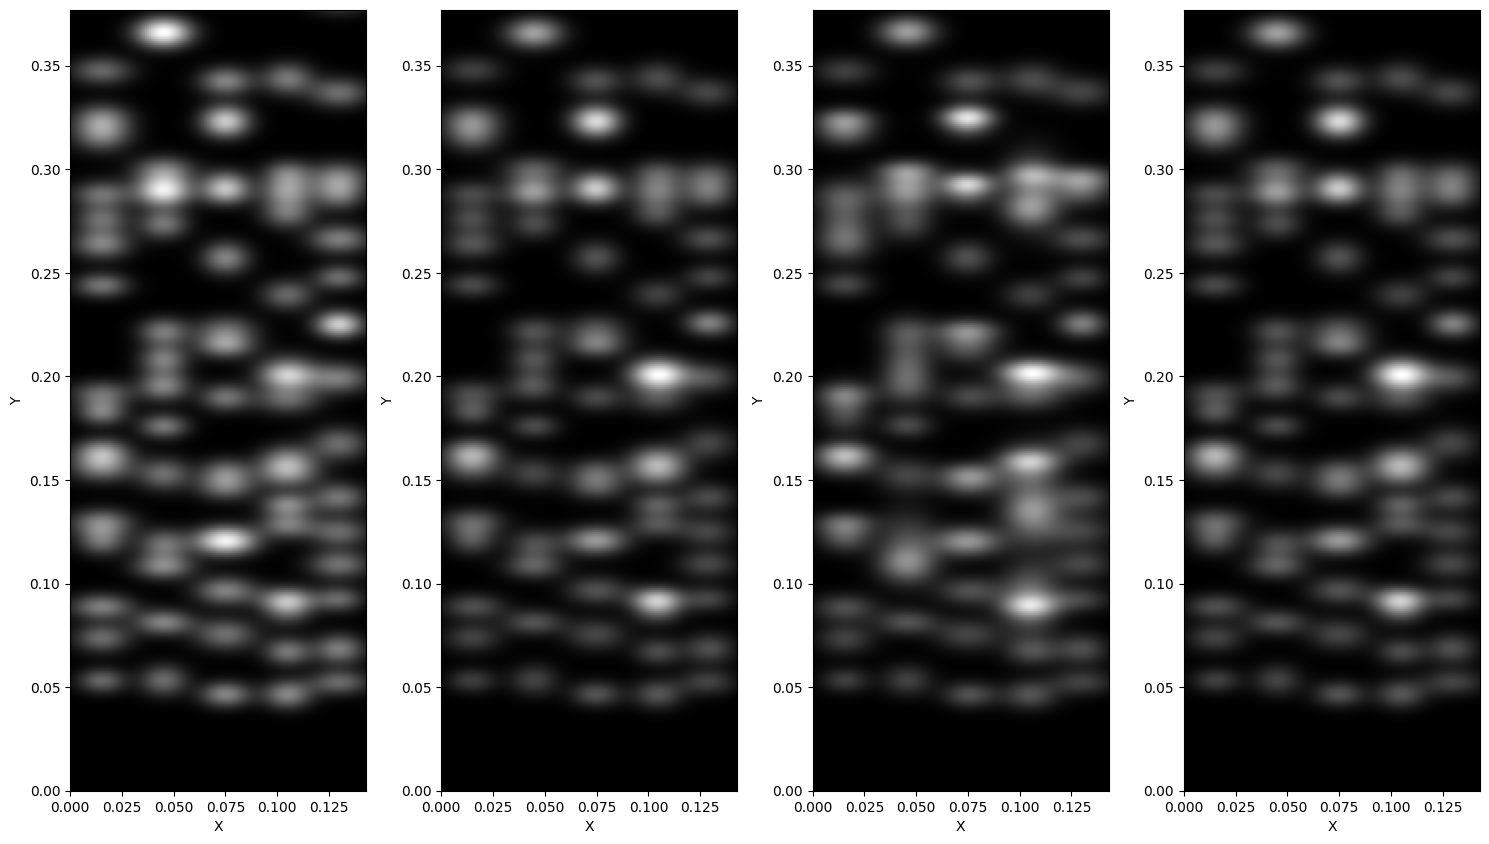

In [ ]:
plt.ion()
plt.tight_layout()
plt.show()

###### Subregion by Gaussian plotting

In [ ]:
n_gaussian = 30
center = all_gaussians[n_gaussian][0]
covariance = all_gaussians[n_gaussian][1]
# Extract region - reconstructed with true one
sub_region = extract_region(generated_z,
                            center,
                            covariance,
                            return_cropped = False)
# Extract region - true one
sub_region_truth = extract_region(image[2],
                                  center,
                                  covariance,
                                  return_cropped = False)

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x,
               y,
               sub_region,
               colorbar = False,
               ax = ax[0])

In [ ]:
# Original image
plot_grayscale(x,
               y,
               sub_region_truth,
               colorbar = False,
               ax = ax[1])

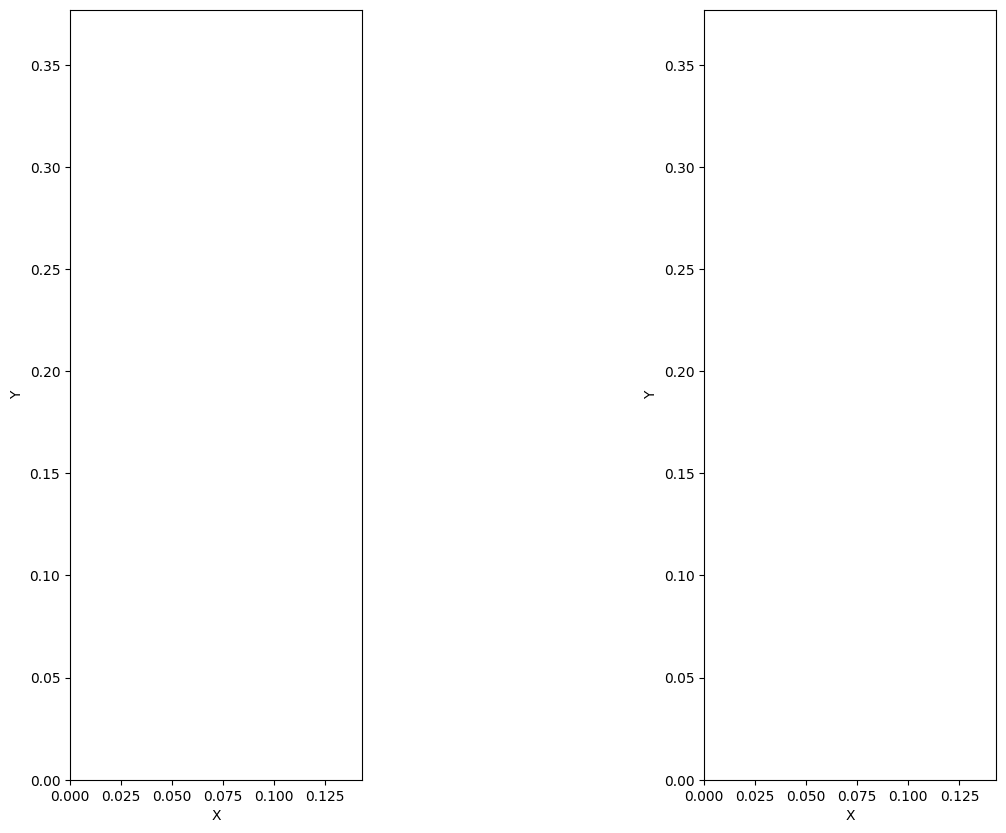

In [ ]:
plt.ion()
plt.show()

###### Cropped region by gaussian plotting

In [ ]:
# Matches Gaussians
row_ind, col_ind = match_gaussians([gaussian[0] for gaussian in all_gaussians_yolo],
                                   list(zip(xs, ys)))

In [ ]:
n_gaussian = 72
n_gaussian_truth = col_ind[np.where(row_ind == n_gaussian)[0]][0]

# YOLO
center = all_gaussians_yolo[n_gaussian][0]
covariance = all_gaussians_yolo[n_gaussian][1]
# Extract region - reconstructed with true one
(sub_region,
 cropped_region,
 _) = extract_region(generated_z_yolo,
                     center,
                     covariance,
                     return_cropped = True)

# Extract region - true one
(sub_region_truth,
 cropped_region_truth,
 region_limits) = extract_region(image[2],
                                 center,
                                 covariance,
                                 return_cropped = True)
# PX
center = all_gaussians_px[n_gaussian][0]
covariance = all_gaussians_px[n_gaussian][1]
# Extract region - reconstructed with true one
(sub_region_px,
 cropped_region_px,
 _) = extract_region(generated_z_px,
                     center,
                     covariance,
                     return_cropped = True)

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(2, 2, figsize = (15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               y[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               cropped_region_truth,
               colorbar = True,
               ax = ax[0, 0])
ax[0, 0].set_title('Ground truth')

# Plot updated centers
ax[0, 0].scatter(xs[n_gaussian_truth],
              ys[n_gaussian_truth],
              s = 3, c = 'green')

In [ ]:
# YOLO image
plot_grayscale(x[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               y[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               cropped_region,
               colorbar = True,
               ax = ax[0, 1])
ax[0, 1].set_title('Yolo prediction')

# Plot updated centers
ax[0, 1].scatter(np.array(means)[:, 0][n_gaussian],
              np.array(means)[:, 1][n_gaussian],
              s = 3, c = 'red')

In [ ]:
# Original image
plot_grayscale(x[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               y[region_limits[0][0] : region_limits[0][1],
                 region_limits[1][0] : region_limits[1][1]],
               cropped_region,
               colorbar = True,
               ax = ax[1, 0])
ax[1, 0].set_title('PX prediction')

# Plot updated centers
ax[1, 0].scatter(np.array(means)[:, 0][n_gaussian],
              np.array(means)[:, 1][n_gaussian],
              s = 3, c = 'red')

In [ ]:
ax[1, 1].axis('off')

(0.0, 1.0, 0.0, 1.0)

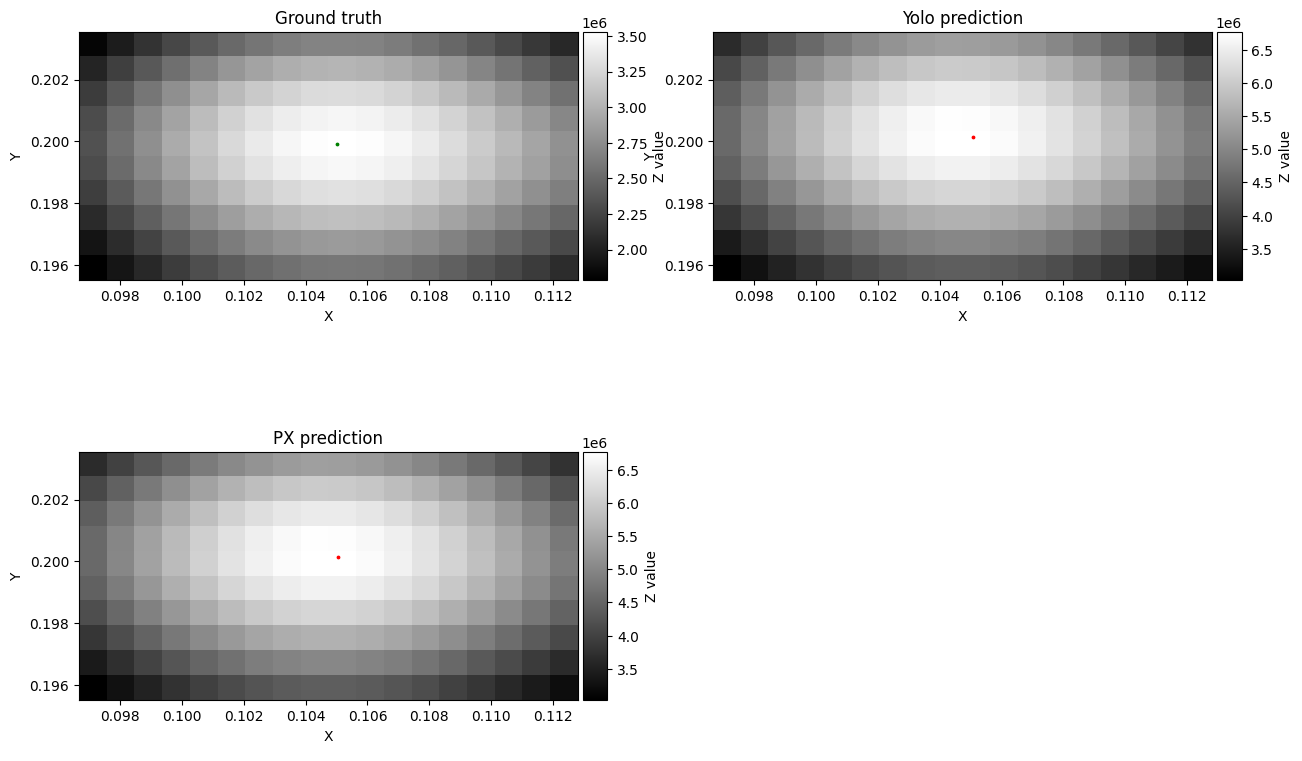

In [ ]:
plt.ion()
plt.show()

#### Evaluate new centers gaussian - NOT Done

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

#### Evaluate new centers yolo

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize = (25, 20))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax)

In [ ]:
# YOLO Check covariance and center are ok
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
task = "detect"
model_name = "YOLOv0_detect"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/2023-07-26_18-50-24/{task}/train/weights/best.pt")

# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = image_ranges,
                                          image_size = image_size)

# Plot box and center
all_texts = all_texts + plot_box_labels(image,
                                  [(x, y) for x, y in means],
                                  [(wx, wy) for wx, wy in
                                   zip(np.sqrt(covariances[:, 0, 0]),
                                       np.sqrt(covariances[:, 1, 1]))],
                                  ax = ax,
                                  center_color = 'b',
                                  annotate_gaussians = True,
                                  text_color = 'blue')


0: 640x256 74 gaussians, 307.3ms
Speed: 1.1ms preprocess, 307.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# n_gaussian_tocheck = 43
# ax.scatter(np.array(means)[n_gaussian_tocheck, 0], np.array(means)[n_gaussian_tocheck, 1], s = 3, c = 'red')

In [ ]:
# Plot box and center
all_texts = all_texts + plot_box_labels(image,
                                        list(zip(xs, ys)),
                                        list(zip(dispersion_x, dispersion_y)),
                                        ax = ax,
                                        box_edge_color = 'g',
                                        center_color = 'g',
                                        annotate_gaussians = True)

In [ ]:
# Plot updated centers
ax.scatter(np.array(converted_new_means)[:, 0],
           np.array(converted_new_means)[:, 1],
           s = 3, c = 'red')

In [ ]:
# Use adjust_text to avoid overlapping for all texts
adjust_text(all_texts)

11

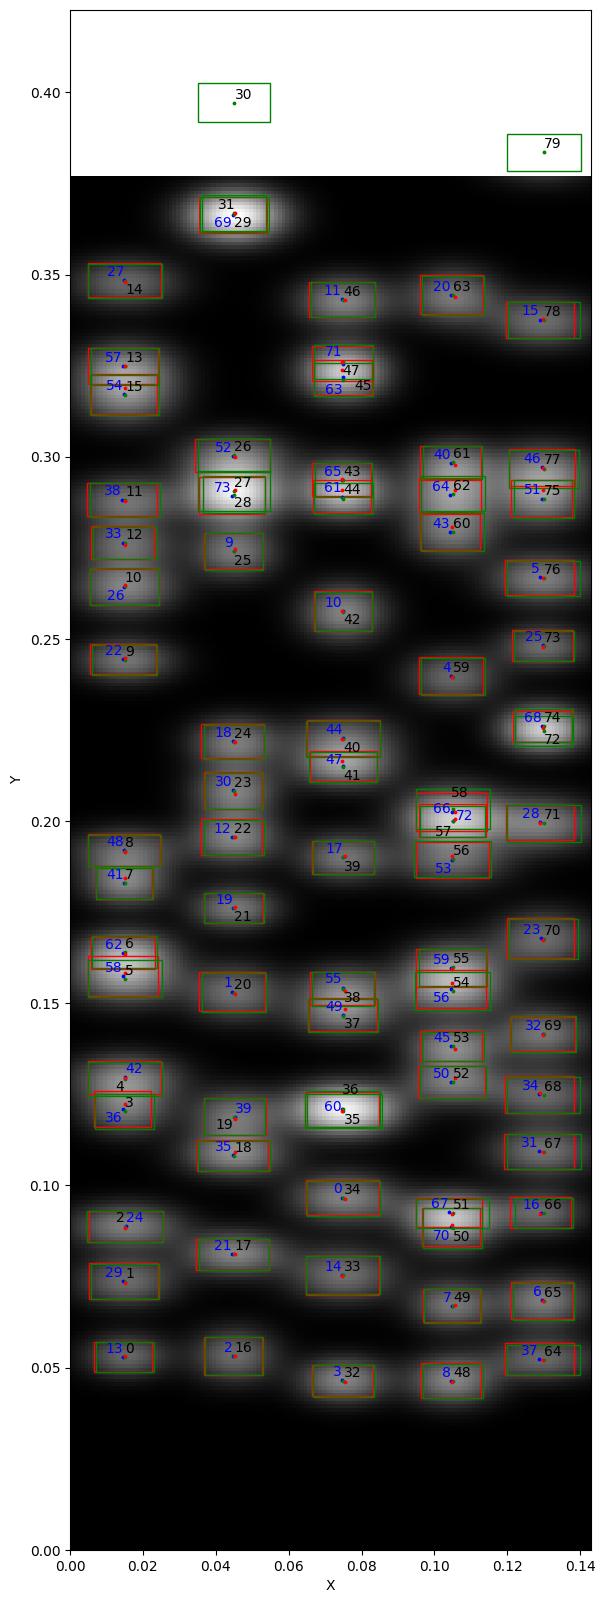

In [ ]:
plt.ion()
plt.show()

## [Estimation] Untangling Gaussians
- When Gaussians sum up in the image, it is not even possible to perfecly identify the centers as one interferes with the other

##### 3D evaluation of region

In [ ]:
# Plot region
n_gaussian_truth = 57
n_gaussian_yolo = 72 # The relation gaussian yolo and true comes from graph

# Center of the image to crop
x_center, y_center = (xs[n_gaussian_truth],
                      ys[n_gaussian_truth])
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian_truth],
                 6 * dispersion_y[n_gaussian_truth])

# Plot points
extra_pts = [{'x': xs[n_gaussian_truth],
              'y': ys[n_gaussian_truth], 'color': 'green'},
             {'x': means[n_gaussian_yolo][0],
              'y': means[n_gaussian_yolo][1], 'color': 'blue'},
             {'x': converted_new_means[n_gaussian_yolo][0],
              'y': converted_new_means[n_gaussian_yolo][1], 'color': 'black'}]

fig = plot_2d_region(image,
               x_center,
               y_center,
               width,
               length,
               colorscale = 'Reds',
               show_points = True,
               annotate = True,
               extra_points = extra_pts)

fig.show()

In [ ]:
# Plot region
n_gaussian = 57
# Center of the image to crop
x_center, y_center = xs[n_gaussian], ys[n_gaussian]
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian],
                 6 * dispersion_y[n_gaussian])
fig = plot_3d_region(image,
                     x_center,
                     y_center,
                     width,
                     length,
                     show_surface = False,
                     colorscale = None,
                     show_points = True,
                     annotate = True)

fig.show()

In [ ]:
# Plot region
n_gaussian = 57
# Center of the image to crop
x_center, y_center = xs[n_gaussian], ys[n_gaussian]
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian],
                 6 * dispersion_y[n_gaussian])
fig = plot_3d_region(image,
                     x_center,
                     y_center,
                     width,
                     length,
                     show_surface = True,
                     colorscale = None,
                     show_points = False,
                     annotate = True)

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# First example of convoluted Gaussians
# Plot region
n_gaussian_truth = 57
n_gaussian_yolo = 72 # The relation gaussian yolo and true comes from graph

# Gaussians summed to the 57
n_gaussians_connected = [56, 58, 71]

# Center of the image to crop
x_center, y_center = (xs[n_gaussian_truth],
                      ys[n_gaussian_truth])
# Width and Height of the image to crop
width, length = (6 * dispersion_x[n_gaussian_truth],
                 6 * dispersion_y[n_gaussian_truth])

# Plot points
extra_pts = [{'x': xs[n_gaussian_truth],
              'y': ys[n_gaussian_truth], 'color': 'green'},
             {'x': means[n_gaussian_yolo][0],
              'y': means[n_gaussian_yolo][1], 'color': 'blue'},
             {'x': converted_new_means[n_gaussian_yolo][0],
              'y': converted_new_means[n_gaussian_yolo][1], 'color': 'black'}]

for n_gaussian_con in n_gaussians_connected:
    extra_pts.append({'x': xs[n_gaussian_con],
                      'y': ys[n_gaussian_con],
                      'color': 'green'})
fig = plot_2d_region(image,
                     x_center,
                     y_center,
                     width,
                     length,
                     colorscale = 'Reds',
                     show_points = True,
                     annotate = True,
                     extra_points = extra_pts)

fig.show()

In [ ]:
# Try using laplacian / derivatives - it may encode the information about the curves not begin "right" because of summing of another Gaussian
# Apriori: Information about local area, number of gaussians and its interferences
# Apriori: Information about gaussians not overlapped, centers and deviation

## Comparison and Sanity check in estimations of GMM, Yolo and truth label
- Clearly sigma x of GMM can be improved
- All covariances before drawing the bounding boxes are multiplied by the sqrt(2)


In [ ]:
# Load data
n_image = 109

# Image - z intensities
image = [x, y, mat['F_data'][:,:, n_image]]

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 3, figsize = (15, 10))

In [ ]:
# True labels
# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(mat['Fit_flux'], n_image)

means = list(zip(xs, ys))
covariances = list(zip(dispersion_x, dispersion_y))

# Plot box and center
plot_box_labels(image,
                means,
                covariances,
                ax = ax[0])

In [ ]:
,# Estimate GMM - Final prediction
(means,
 covariances,
 angles,
 amplitudes) = ppl_fit_gaussians(image,
                                 means_init = 'laplace',
                                 peak_method = 'laplace',
                                 em_iterations = 1000,
                                 covariance_gaussians_type = 'diag',
                                 n_gaussians = None,
                                 image_ranges = [(0, 0.143), (0, 0.377)],
                                 image_size = [143, 377],
                                 fig_size = (10, 8),
                                 plot = False,
                                 plot_points = False)


# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in zip(np.sqrt(covariances[:, 0, 0]),
                                            np.sqrt(covariances[:, 1, 1]))],
                ax = ax[2])

estimate_parameters_gmm executed in 1.439413070678711 seconds
ppl_fit_gaussians executed in 1.4651055335998535 seconds


In [ ]:
# YOLO Check covariance and center are ok
image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"
task = "detect"
model_name = "YOLOv0_detect"

image_path = f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Data/Images/gaussian_{n_image}.png"

# Load our custom model
model = YOLO(f"/content/gdrive/MyDrive/Colab Notebooks/2023/Tesi/Models/{model_name}/runs/2023-07-26_18-50-24/{task}/train/weights/best.pt")

# Predict
(means,
 covariances,
 amplitudes) = ppl_yolo_predict_gaussians(mat,
                                          n_image,
                                          model,
                                          image_path,
                                          image_ranges = [(0, 0.143),
                                                          (0, 0.377)],
                                          image_size = [143, 377])

plot_grayscale(x, y, mat['F_data'][:,:, n_image],
               colorbar = False,
               ax = ax[1])

# Plot box and center
plot_box_labels(image,
                [(x, y) for x, y in means],
                [(wx, wy) for wx, wy in zip(np.sqrt(covariances[:, 0, 0]),
                                            np.sqrt(covariances[:, 1, 1]))],
                ax = ax[1])


0: 640x256 74 gaussians, 354.9ms
Speed: 2.5ms preprocess, 354.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
np.sqrt(2 * np.log(2))

1.1774100225154747

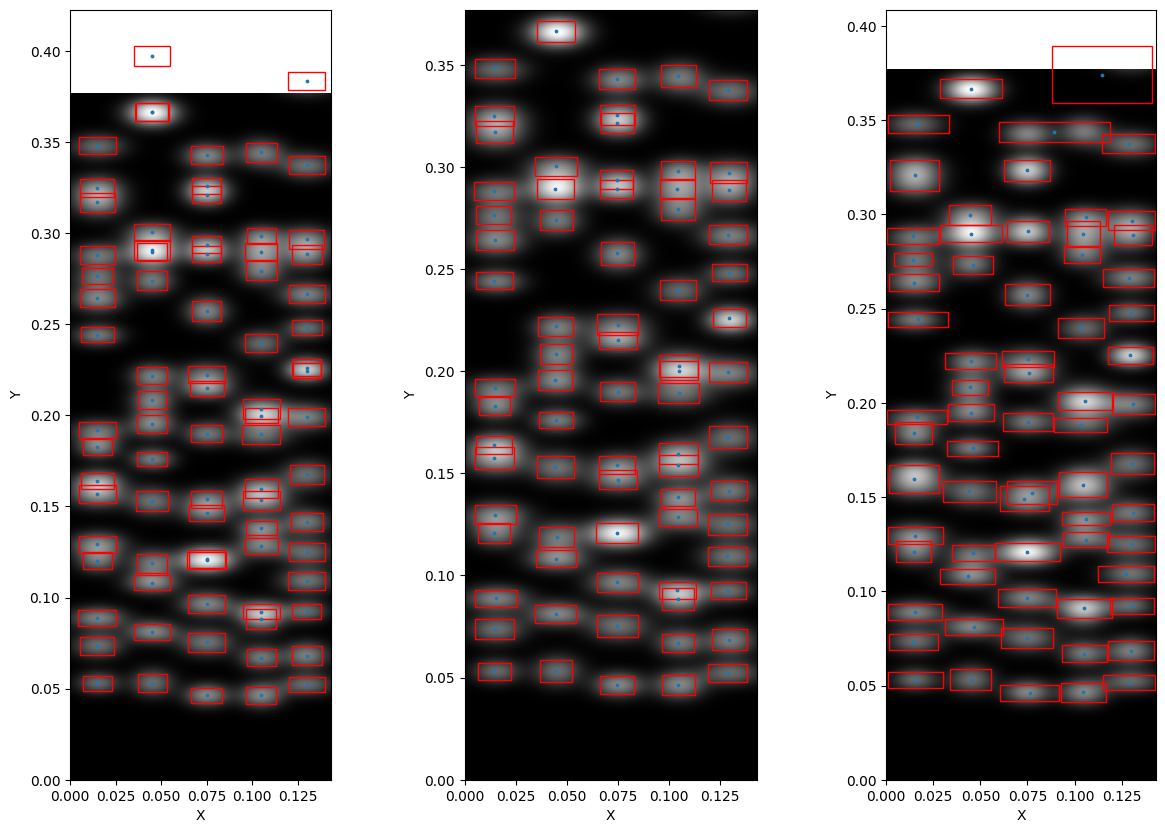

In [ ]:
# show plots
plt.show()
plt.ion()

# Annotations

## SPIDER
- Radius of each hole in the grid is 14 mm (hemsworth1996 - Original NB design);
- Design assumed the beams as two Gaussian parts, core with the 85% power with divergence of 5 mrad and the halo (15% power) with poor divergence of > 15 mrad (hemsworth1996 - Original NB design);
- Expected core beamlet divergence of as low as 2 - 3 mrad (hemsworth1996 - reference 11)

# Pipeline ppl_RNN
- Work of numbers from kaparty
- MASK R-CNN

# Pipeline ppl_CNN
  - Use a CNN to identify the Gaussians
    - Many questions, for example, how to analyse the whole image?
    - Yolo architecture of boxing/training might be a way
  - Check RetinaNet:
    - https://developers.arcgis.com/python/guide/how-retinanet-works/